In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib as mpl
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from astropy.convolution.kernels import CustomKernel

import time

# from sklearn import gaussian_process
# from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

In [2]:
%matplotlib inline

In [3]:
plt.style.use('court.mplstyle')

In [4]:
from scipy.interpolate import PchipInterpolator

In [5]:
# https://dsp.stackexchange.com/questions/1676/savitzky-golay-
#smoothing-filter-for-not-equally-spaced-data

def non_uniform_savgol(x, y, window, polynom):
    """
    Applies a Savitzky-Golay filter to y with non-uniform spacing
    as defined in x

    This is based on https://dsp.stackexchange.com/questions/1676/
    savitzky-golay-smoothing-filter-for-not-equally-spaced-data
    The borders are interpolated like scipy.signal.savgol_filter would do

    Parameters
    ----------
    x : array_like
        List of floats representing the x values of the data
    y : array_like
        List of floats representing the y values. Must have same length
        as x
    window : int (odd)
        Window length of datapoints. Must be odd and smaller than x
    polynom : int
        The order of polynom used. Must be smaller than the window size

    Returns
    -------
    np.array of float
        The smoothed y values
    """
    if len(x) != len(y):
        raise ValueError('"x" and "y" must be of the same size')

    if len(x) < window:
        raise ValueError('The data size must be larger than the window size')

    if type(window) is not int:
        raise TypeError('"window" must be an integer')

    if window % 2 == 0:
        raise ValueError('The "window" must be an odd integer')

    if type(polynom) is not int:
        raise TypeError('"polynom" must be an integer')

    if polynom >= window:
        raise ValueError('"polynom" must be less than "window"')

    half_window = window // 2
    polynom += 1

    # Initialize variables
    A = np.empty((window, polynom))     # Matrix
    tA = np.empty((polynom, window))    # Transposed matrix
    t = np.empty(window)                # Local x variables
    y_smoothed = np.full(len(y), np.nan)

    # Start smoothing
    for i in range(half_window, len(x) - half_window, 1):
        # Center a window of x values on x[i]
        for j in range(0, window, 1):
            t[j] = x[i + j - half_window] - x[i]

        # Create the initial matrix A and its transposed form tA
        for j in range(0, window, 1):
            r = 1.0
            for k in range(0, polynom, 1):
                A[j, k] = r
                tA[k, j] = r
                r *= t[j]

        # Multiply the two matrices
        tAA = np.matmul(tA, A)

        # Invert the product of the matrices
        tAA = np.linalg.inv(tAA)

        # Calculate the pseudoinverse of the design matrix
        coeffs = np.matmul(tAA, tA)

        # Calculate c0 which is also the y value for y[i]
        y_smoothed[i] = 0
        for j in range(0, window, 1):
            y_smoothed[i] += coeffs[0, j] * y[i + j - half_window]

        # If at the end or beginning, store all coefficients for the polynom
        if i == half_window:
            first_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    first_coeffs[k] += coeffs[k, j] * y[j]
        elif i == len(x) - half_window - 1:
            last_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    last_coeffs[k] += coeffs[k, j] * y[len(y) - window + j]

    # Interpolate the result at the left border
    for i in range(0, half_window, 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += first_coeffs[j] * x_i
            x_i *= x[i] - x[half_window]

    # Interpolate the result at the right border
    for i in range(len(x) - half_window, len(x), 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += last_coeffs[j] * x_i
            x_i *= x[i] - x[-half_window - 1]

    return y_smoothed

def find_runs(x):
    x = np.asanyarray(x)
    n = x.shape[0]
    
    # find run starts
    loc_run_start = np.empty(n, dtype=bool)
    loc_run_start[0] = True
    np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
    run_starts = np.nonzero(loc_run_start)[0]

    # find run values
    run_values = x[loc_run_start]

    # find run lengths
    run_lengths = np.diff(np.append(run_starts, n))

    return run_values, run_starts, run_lengths

In [6]:
def decline_detection(data_frame,decline_min_depth=0.9,saturation_limit=12,
                      use_iter_smooth=False,debug_mode=False,savefile=None):
    ##############################################
    ## note that the DataFrame must have a 'jd' column and a 'mag' column
    ##############################################

    ##############################################
    ## zeropoint so we don't have to do it forever
    ##############################################
    mjd_scale = data_frame['jd'][0]

    ##############################################
    ## apply a savgol filter to remove outliers
    ##############################################
    ### will fail if duplicate data points
    savgol_filtered = non_uniform_savgol(np.asarray(data_frame['jd']-mjd_scale),
                                         np.asarray(data_frame['mag']),
                                       window=7, polynom=1)
    
    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(data_frame['jd']-mjd_scale,data_frame['mag'],s=15,
                    c=savgol_filtered-data_frame['mag'],cmap='bwr',edgecolor='k',linewidth=0.5)
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('magnitude')
        plt.colorbar(label='savgol residual')
        plt.title('Savgol residual on original data')
        # plt.clim(vmax=-1)
        plt.clim(-1,1)
        plt.show()

    ## measure the std deviation of the savgol filtering
    ## we will kick out data points with residuals bigger than this
    deviation = np.std(savgol_filtered-data_frame['mag'])
    percentile = np.percentile(savgol_filtered-data_frame['mag'],95)
    percentile2 = np.percentile(savgol_filtered-data_frame['mag'],99)
    if debug_mode==True:
        print('Std dev:',deviation)
        print('95 percentile:',percentile)
        print('99 percentile:',percentile2)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(data_frame['jd']-mjd_scale,savgol_filtered-data_frame['mag'],s=10)
        plt.axhline(deviation,color='k',linestyle='--')
        plt.axhline(-deviation,color='k',linestyle='--')
        plt.axhline(percentile,color='red',linestyle='--')
        plt.axhline(-percentile,color='red',linestyle='--')
        plt.axhline(percentile2,color='green',linestyle='--')
        plt.axhline(-percentile2,color='green',linestyle='--')
        # plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('residuals to savgol filter')
        plt.title('savgol filter residuals with the cutoff labelled')
        plt.ylim(-1,1)
        plt.show()

    ## the actual mask for the savgol filtering
    mask = np.where(np.abs(savgol_filtered-data_frame['mag'])<percentile,True,False)
    ## add in a mask for bad measurements 1.5 mag above the saturation limit
    mask_satlim = np.where(data_frame['mag']<saturation_limit-1.5,False,True)
    mask = mask & mask_satlim

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(data_frame['jd'][mask]-mjd_scale,data_frame['mag'][mask],s=10)
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('magnitude')
        plt.title('Savgol filtered data')
        plt.show()

    ## apply the mask for savgol filtering
    savgol_filtered_frame = data_frame.iloc[mask]
    savgol_filtered_frame.reset_index(drop=True,inplace=True)
    # savgol_filtered_oband
    if savgol_filtered_frame['jd'][0] != mjd_scale:
        print('filtered first data point, resetting mjd_scale')
        mjd_scale = savgol_filtered_frame['jd'][0]

    ##############################################
    ## savgol filter to smooth the data
    ##############################################
    ## make another, more aggressive savgol filter to smooth the data
    iter_savgol_filtered = non_uniform_savgol(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
                                         np.asarray(savgol_filtered_frame['mag']),
                                       window=31, polynom=1)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(savgol_filtered_frame['jd']-mjd_scale,savgol_filtered_frame['mag'],s=10,
                    c=iter_savgol_filtered-savgol_filtered_frame['mag'],cmap='bwr')
        plt.colorbar(label='iterated savgol residual')
        plt.scatter(savgol_filtered_frame['jd']-mjd_scale,iter_savgol_filtered,s=10,alpha=0.5,color='k')
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('savgol filtered magnitude')
        plt.title('Savgol for smoothing (iter)')
        plt.show()

    ##############################################
    ## create a mask for the regions which are saturated
    ## this will need to be edited for things that aren't ATLAS
    ##############################################
    # I think we can use that ATLAS saturates at around 11 mag # r ~ 12.5
    # and limiting mag is ~20
    local_std = np.std((iter_savgol_filtered-savgol_filtered_frame['mag']))
#     saturation_limit = 0#12
    saturation_mask = []
#     variation_arr = []
    halfwidth=10
#     print('saturation_masking')
#     print('savgol length:',len(savgol_filtered_frame))
#     print('iter length:',len(iter_savgol_filtered))
    for i in range(0,len(savgol_filtered_frame)):
#         print(i)
        if i > int(len(savgol_filtered_frame)-halfwidth-1):
            saturation_mask.append(True)
#             print('end of array')
#             variation_arr.append(0)
        elif int(i < halfwidth):
            saturation_mask.append(True)
#             print('beginning of array')
#             variation_arr.append(0)
        else:
            variation_window = np.max(np.abs(iter_savgol_filtered[i-halfwidth:i+halfwidth]-savgol_filtered_frame['mag'][i-halfwidth:i+halfwidth]))
            time_res = savgol_filtered_frame['jd'][i+halfwidth] - savgol_filtered_frame['jd'][i-halfwidth]
            #             variation_arr.append(variation_window)
#             print('variation window',variation_window)
            if (variation_window > 0.1 and time_res < 50 and
                np.mean(savgol_filtered_frame['mag'][i-halfwidth:i+halfwidth])<saturation_limit):
#                 time_res = savgol_filtered_frame['jd'][i+halfwidth] - savgol_filtered_frame['jd'][i-halfwidth]
#                 print('time res', time_res)
        #         print('mask me')
                saturation_mask.append(False)
            else:
                saturation_mask.append(True)
#     variation_arr = np.asarray(variation_arr)
    saturation_mask = np.asarray(saturation_mask)

    if debug_mode==True:
#         plt.figure(figsize=(14,6))
#         plt.scatter(savgol_filtered_frame['jd']-mjd_scale,savgol_filtered_frame['mag'],s=10,alpha=0.5)
#         plt.scatter(savgol_filtered_frame['jd'][saturation_mask]-mjd_scale,savgol_filtered_frame['mag'][saturation_mask],s=10,
#                     c=variation_arr[:-1],cmap='bwr')
#         # plt.scatter(savgol_filtered_frame['jd'][np.invert(saturation_mask)]-mjd_scale,
#         #            saturation_replace[np.invert(saturation_mask)],color='darkgrey')
#         plt.colorbar(label='variation window')
#         plt.clim(-0.5,0.5)
#         # plt.scatter(savgol_filtered_frame['jd']-mjd_scale,iter_savgol_filtered,s=10,alpha=0.5)
#         plt.gca().invert_yaxis()
#         plt.xlabel('jd - '+str(mjd_scale))
#         plt.ylabel('savgol filtered magnitude')
#         plt.title('checking the variation window argument for saturation masking')
#         # plt.colorbar(label='iterated savgol residual')
#         # plt.clim(vmax=-1)
#         # plt.clim(vmin=-2)
#         plt.show()
        
        
        plt.figure(figsize=(14,6))
        plt.scatter(savgol_filtered_frame['jd']-mjd_scale,savgol_filtered_frame['mag'],s=10,alpha=0.5)
        plt.scatter(savgol_filtered_frame['jd'][saturation_mask]-mjd_scale,savgol_filtered_frame['mag'][saturation_mask],s=10,
                    c=iter_savgol_filtered[saturation_mask]-savgol_filtered_frame['mag'][saturation_mask],cmap='bwr')
        plt.colorbar(label='iterated savgol residual')
        plt.clim(-1,1)
        plt.scatter(savgol_filtered_frame['jd'][~saturation_mask]-mjd_scale,savgol_filtered_frame['mag'][~saturation_mask],
                    s=10,color='k')
        # plt.scatter(savgol_filtered_frame['jd'][np.invert(saturation_mask)]-mjd_scale,
        #            saturation_replace[np.invert(saturation_mask)],color='darkgrey')
        # plt.scatter(savgol_filtered_frame['jd']-mjd_scale,iter_savgol_filtered,s=10,alpha=0.5)
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('savgol filtered magnitude')
        # plt.colorbar(label='iterated savgol residual')
#         plt.clim(vmin=-2)
        plt.show()



    ##############################################
    ## decide on the iter smooth or the original data
    ##############################################
    if use_iter_smooth==True:
        ## make another, more aggressive savgol filter to smooth the data
        iter_savgol_filtered = non_uniform_savgol(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
                                             np.asarray(savgol_filtered_frame['mag']),
                                           window=7, polynom=1)
#         savgol_filtered_frame['mag'] = iter_savgol_filtered


    ##############################################
    ## interpolate the data to get evenly sampled data
    ##############################################
    # interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
    #                                                  np.asarray(iter_savgol_filtered),
    #                                                  kind='linear')
    if use_iter_smooth==True:
        interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
                                                         np.asarray(iter_savgol_filtered),
                                                         kind='linear')
    else:
        interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
                                                         np.asarray(savgol_filtered_frame['mag']),
                                                         kind='linear')

    ### attempting monotone interpolants ###
    # interpolation_function = PchipInterpolator(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
    #                                                  np.asarray(iter_savgol_filtered)) # this one is better
    # interpolation_function = PchipInterpolator(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
    #                                                  np.asarray(savgol_filtered_frame['mag'])) # this one is better


    ## what time resolution? I don't want to lose any of the real data if possible
    real_resolution = np.average(np.diff(savgol_filtered_frame['jd']))
    if debug_mode==True:
        print('data resolution:', real_resolution)
    len_data = np.max(savgol_filtered_frame['jd']-mjd_scale)
    resample_time = np.linspace(0,len_data,int(len_data)) # declines don't matter closer than this
    ## currently resampling at a resolution of 1 day
    resample_flux = interpolation_function(resample_time)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10)
        plt.scatter(np.asarray(savgol_filtered_frame['jd']-mjd_scale),np.asarray(iter_savgol_filtered),s=10)
        plt.scatter(np.asarray(savgol_filtered_frame['jd']-mjd_scale),np.asarray(savgol_filtered_frame['mag']),s=10)
        plt.gca().invert_yaxis()
        plt.xlabel('resampled jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.title('checking the interpolation method with the smooth/orig data')
        # plt.ylim(20.5,11)
        # plt.ylim(14,11)
        # plt.xlim(1000,1200)
        plt.show()

#     ##############################################
#     ## edge detection via convolution - this is identical to gradient but slower
#     ##############################################
#     start = time.time()
#     new_edge_detect = sp.ndimage.convolve(resample_flux, [1.0, 0.0, -1.0])
#     end = time.time()
#     print('convolution edges time:', end - start)

#     if debug_mode==True:
#         plt.figure(figsize=(14,6))
#         plt.scatter(resample_time,new_edge_detect,s=10)
#         plt.xlabel('jd - '+str(mjd_scale))
#         plt.ylabel('edge detection')
#         plt.title('edge detection via convolution')
#         # plt.ylim(-1,1)
#         plt.show()

#         plt.figure(figsize=(14,6))
#         # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
#         plt.scatter(resample_time,resample_flux,s=10,
#                     c=new_edge_detect,cmap='bwr')#,alpha=0.2)
#         # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
#         plt.gca().invert_yaxis()
#         plt.xlabel('resampled jd - '+str(mjd_scale))
#         plt.ylabel('interpolated magnitude')
#         plt.colorbar(label='edge detect')
#         plt.clim(-0.1,0.1)
#         plt.title('plotting edge detection via convolution on the original data')
#         plt.show()

#     ##############################################
#     ## creating a mask for when edge detect is positive
#     ##############################################
#     # std_dev = np.std(new_edge_detect)
#     # # std_dev
#     # new_mask = np.where(np.abs(new_edge_detect)>(std_dev*0.25),True,False)
#     new_mask = np.where(np.abs(new_edge_detect)>0,True,False)

#     if debug_mode==True:
#         plt.figure(figsize=(14,6))
#         # plt.scatter(data_frame['jd'][mask]-mjd_scale,(gp_edges+3)*4,s=10)
#         plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
#         plt.scatter(resample_time[new_mask],resample_flux[new_mask],s=10,
#                     c=new_edge_detect[new_mask],cmap='bwr')
#         plt.gca().invert_yaxis()
#         plt.xlabel('jd - '+str(mjd_scale))
#         plt.ylabel('interpolated magnitude')
#         plt.colorbar(label='edge detect')
#         plt.title('positive in edge detection via convolution')
#         plt.clim(-0.1,0.1)
#         # plt.xlim(950,1200)
#         # plt.xlim(500,1000)
#         plt.show()

#     ##############################################
#     ## create mask for edge detection significantly positive
#     ##############################################
#     std_dev = np.std(new_edge_detect)
#     new_mask = np.where(np.abs(new_edge_detect)>(std_dev*0.25),True,False)
#     downslope_mask = np.where(new_edge_detect>0.0,True,False)
#     total_mask = new_mask & downslope_mask

#     if debug_mode==True:
#         plt.figure(figsize=(14,6))
#         # plt.scatter(data_frame['jd'][mask]-mjd_scale,(gp_edges+3)*4,s=10)
#         plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
#         plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
#                     c=new_edge_detect[total_mask],cmap='bwr')
#         plt.gca().invert_yaxis()
#         plt.xlabel('jd - '+str(mjd_scale))
#         plt.ylabel('interpolated magnitude')
#         plt.title('masked for edge detection significantly positive')
#         plt.colorbar(label='edge detect')
#         plt.clim(-0.1,0.1)
#         # plt.xlim(950,1200)
#         # plt.xlim(500,1000)
#         plt.show()

    ##############################################
    ## edge detection via gradients
    ##############################################
#     start = time.time()
    gradient = np.gradient(resample_flux, resample_time)
    smooth_gradient = non_uniform_savgol(resample_time,
                                        gradient,
                                        window=7, polynom=1)
#     smooth_gradient = convolve(gradient, Box1DKernel(7))
    second_gradient = np.gradient(smooth_gradient, resample_time)
#     end = time.time()
#     print('gradient edges time:', end - start)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,gradient,s=10)
        plt.axhline(0.0,color='k',linestyle='--')
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('gradient')
        plt.title('the gradient')
        plt.ylim(-0.25,0.25)
        plt.show()
        
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,smooth_gradient,s=10)
        plt.axhline(0.0,color='k',linestyle='--')
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('smooth gradient')
        plt.title('the smoothed gradient')
        plt.ylim(-0.25,0.25)
        plt.show()
        
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,second_gradient,s=10)
        plt.axhline(0.0,color='k',linestyle='--')
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('second gradient')
        plt.title('the second gradient')
#         plt.ylim(-0.25,0.25)
        plt.show()

#         plt.figure(figsize=(14,6))
#         plt.scatter(resample_time,(gradient/np.max(gradient))-(new_edge_detect/np.max(new_edge_detect)),s=10)
#         plt.xlabel('jd - '+str(mjd_scale))
#         plt.ylabel('diff between gradient and convolution edges')
#         plt.ylim(-0.25,0.25)
#         plt.show()

        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10,
                    c=gradient,cmap='bwr')
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.colorbar(label='gradient')
        plt.title('edge detection via the gradient')
        plt.clim(-0.1,0.1)
        plt.show()
        
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10,
                    c=smooth_gradient,cmap='bwr')
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.colorbar(label='smooth gradient')
        plt.title('edge detection via the smoothed gradient')
        plt.clim(-0.1,0.1)
        plt.show()
        
#         plt.figure(figsize=(14,6))
#         plt.scatter(resample_time,gradient,s=15,
#                     c=second_gradient,cmap='bwr',edgecolor='k',linewidth=0.5)
# #         plt.gca().invert_yaxis()
#         plt.xlabel('jd - '+str(mjd_scale))
#         plt.ylabel('gradient')
#         plt.colorbar(label='second gradient')
#         plt.title('gradient with the second gradient')
#         plt.clim(-0.1,0.1)
#         plt.xlim(1500,2000)
#         plt.show()

    ##############################################
    ## mask for where gradient is positive
    ##############################################
    downslope_mask = np.where(smooth_gradient>0,True,False)
#     downslope_mask = np.where(gradient>0,True,False)
    total_mask = downslope_mask

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
        plt.scatter(resample_time[downslope_mask],resample_flux[downslope_mask],s=10,
                    c=gradient[downslope_mask],cmap='bwr')
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.colorbar(label='gradient')
        plt.title('positive gradient mask')
        plt.clim(-0.1,0.1)
        plt.show()

    ##############################################
    ## find the runs of positive and negative values
    ##############################################
    run_vals, run_start, run_length = find_runs(total_mask)

    downward_mask = run_start[np.logical_and(run_vals==True,run_length > 3)]
    upward_mask = run_start[np.logical_and(run_vals==False,run_length > 3)]

    ## generation of the actual decline onsets
    ## this is the meat of the code
    if debug_mode==True:
        print('actually detecting the declines')
#     decline_min_depth = 0.9
    decline_onset = []
    decline_end = []
    decline_depth = []
    for i in range(0,len(resample_flux[run_start])):
        ####################################################################
        if i == 0 and resample_flux[0] > (np.min(resample_flux)+decline_min_depth):
            # and np.abs(resample_flux[0] - resample_flux[run_start[i+1]]) > decline_min_depth:
            ## two possible cases: either starts going down or starts going up
            ## either way, they should BOTH start below the decline threshold
            ## adding the absolute magnitude should detect beginning declines
            ## NEEDS TO BE TESTED - has been tested a little bit, needs more
            decline_onset.append(0)
            if debug_mode==True:
                print('beginning i=0')
                print(resample_flux[0])
#                 print(np.abs(resample_flux[0] - resample_flux[run_start[i]]))
            decline_end.append(run_start[i+1])
            decline_depth.append(np.abs(resample_flux[0] - resample_flux[run_start[i+1]]))
            ####################################################################
        elif i == len(resample_flux[run_start])-1:
            if resample_flux[-1] - resample_flux[run_start[i]] > decline_min_depth:
                decline_onset.append(run_start[i])
                if debug_mode==True:
                    print('end')
                    print(run_start[i])
                    print(resample_flux[run_start[i]])
                    print(resample_flux[-1] - resample_flux[run_start[i]])
                decline_end.append(len(resample_flux)-1)
                decline_depth.append(resample_flux[-1] - resample_flux[run_start[i]])
        elif resample_flux[run_start[i+1]] - resample_flux[run_start[i]] > decline_min_depth:#1:
            decline_onset.append(run_start[i])
            if debug_mode==True:
                print(run_start[i])
                print(resample_flux[run_start[i]])
                print(resample_flux[run_start[i+1]] - resample_flux[run_start[i]])
            decline_end.append(run_start[i+1])
            decline_depth.append(resample_flux[run_start[i+1]] - resample_flux[run_start[i]])
    #     if i == len(resample_flux[run_start]):
    #         print('end')
    if debug_mode==True:
        print(resample_flux[decline_end])
        print(decline_depth)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
        plt.scatter(resample_time[downward_mask],
                    np.full(len(resample_time[downward_mask]),np.min(resample_flux))-0.2,
                    s=20,marker='x',color='k',zorder=3)
        plt.scatter(resample_time[upward_mask],
                    np.full(len(resample_time[upward_mask]),np.min(resample_flux))-0.2,
                            s=20,marker='x',color='tab:green',zorder=3)
        plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
                    c=(gradient[total_mask]),cmap='bwr')

        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.colorbar(label='gradient')
        plt.clim(-0.1,0.1)
        plt.title('all the original run masks')
        plt.show()

        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
        plt.scatter(resample_time[decline_onset],
                    np.full(len(resample_time[decline_onset]),np.min(resample_flux))-0.2,
                            s=20,marker='x',color='k',zorder=3)
        plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
                    c=(gradient[total_mask]),cmap='bwr')

        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.colorbar(label='gradient')
        plt.title('the better run masks with the gradient mask')
        plt.clim(-0.1,0.1)
        plt.show()

    ## more of the meat here
    ## turning the masks into real data points
    plt.figure(figsize=(14,6))
    plt.scatter(resample_time,resample_flux,s=10,color='lightsteelblue')
    plt.scatter(savgol_filtered_frame['jd']-mjd_scale,savgol_filtered_frame['mag'],
                s=10,color='darkgrey')
    plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
                c=(gradient[total_mask]),cmap='bwr',alpha=0.2)
    plt.clim(-0.1,0.1)

    onset_arr = []
    onset_flag = []
    max_depth_arr = []
    end_arr = []
    end_flag = []

    max_light = np.min(resample_flux)
    plt.axhline(max_light,color='k',linestyle='--')
    plt.axhline(max_light+decline_min_depth,color='k',linestyle='--',alpha=0.5)
    for i in range(0,len(resample_time[decline_onset])):
        flag_set = False
        if decline_onset[i] == 0:
    #         print('beginning of array')
            onset_flag.append(1)
            flag_set = True
        onset_time = resample_time[decline_onset][i]
        diff_arr = np.abs((savgol_filtered_frame['jd'][saturation_mask]-mjd_scale)-onset_time)
        diff_arr_normal = np.abs((savgol_filtered_frame['jd']-mjd_scale)-onset_time)
#         if debug_mode == True:
#             print('min diff_arr',np.min(diff_arr))
#             print('min diff_arr_normal',np.min(diff_arr_normal))
        if np.min(diff_arr) > 5:
            if decline_depth[i] > decline_min_depth+1:#12-np.min(savgol_filtered_frame['mag']):
                plt.axvline(onset_time,color='red',linestyle='--')
                plt.axvline(resample_time[decline_end[i]],color='grey',linestyle='--',alpha=0.5)
    #             plt.axhline(max_light+decline_min_depth+decline_depth[i],color='k',linestyle='--')
                onset_arr.append(onset_time)
                max_depth_arr.append(resample_time[decline_end[i]])
                if flag_set == False:
                    onset_flag.append(2)
    #             print('onset', onset_time)
            else:
                if debug_mode == True:
                    print('bad onset')
                plt.axvline(onset_time,color='k',linestyle='--')
                onset_flag.append(3)
                onset_arr.append(onset_time)
                max_depth_arr.append(resample_time[decline_end[i]])
                pass
    #             plt.axvline(onset_time,color='red',linestyle='--')
        else:
            plt.axvline(onset_time,color='green',linestyle='--',alpha=0.5)
            plt.axvline(resample_time[decline_end[i]],color='grey',linestyle='--',alpha=0.5)
    #         plt.axhline(max_light+decline_min_depth+decline_depth[i],linestyle='--')
            if flag_set == False:
                onset_flag.append(0)
            onset_arr.append(onset_time)
            max_depth_arr.append(resample_time[decline_end[i]])
    #         print('onset', onset_time)

        post_decline_time = resample_time[resample_time>onset_time]
        post_decline_flux = resample_flux[resample_time>onset_time]
        xx = 0
        while post_decline_flux[xx] < (max_light+decline_min_depth):
            xx=xx+1
        else:
    #         print('exited max light')
            exit_time = post_decline_time[xx]
            post_decline_time = resample_time[resample_time>exit_time]
            post_decline_flux = resample_flux[resample_time>exit_time]

        xx = 0
        try:
            while post_decline_flux[xx] > (max_light+decline_min_depth):
                xx=xx+1
            else:
    #             print('reached max light')
    #             print(xx,post_decline_flux[xx],post_decline_time[xx])
                if onset_flag[-1] != 3:
                    plt.axvline(post_decline_time[xx],color='blue',linestyle='--',alpha=0.5)
                end_arr.append(post_decline_time[xx])
                end_flag.append(0)
        except IndexError:
    #         print('reached end of array')
    #         print(xx-1,post_decline_flux[xx-1],post_decline_time[xx-1])
            if onset_flag[-1] != 3:
                plt.axvline(post_decline_time[xx-1],color='blue',linestyle='--',alpha=0.5)
            end_arr.append(post_decline_time[xx-1])
            end_flag.append(1)

    # print(onset_arr)
    # print(onset_flag)
    # print(end_arr)
    # print(end_flag)
    # print(max_depth_arr)

    plt.scatter(resample_time[decline_onset][np.asarray(onset_flag) != 3],
                np.full(len(resample_time[decline_onset][np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.2,
                        s=20,marker='x',color='k',zorder=3)

    for i in range(0,len(onset_arr)):
        if onset_flag[i] != 3:
            plt.axvspan(onset_arr[i], end_arr[i], alpha=0.1, color='grey')

    plt.gca().invert_yaxis()
    plt.xlabel('jd - '+str(mjd_scale))
    plt.ylabel('savgol filtered magnitude')
    plt.title('setting the onsets and the flags')
    plt.show()

    ## resample the times back to the original data set
    orig_time = savgol_filtered_frame['jd']-mjd_scale
#     print('onsets')
    onset_arr_orig = return_arr_to_orig(onset_arr,orig_time,savgol_filtered_frame['mag'],
                                        onset_flag,arr_type='onset')
#     print('ends')
    end_arr_orig = return_arr_to_orig(end_arr,orig_time,savgol_filtered_frame['mag'],
                                      onset_flag,arr_type='end')
    depth_time_orig = return_arr_to_orig(max_depth_arr,orig_time,savgol_filtered_frame['mag'],
                                         onset_flag,arr_type='depth')

    ## calculate errors
    onset_err_arr_l,onset_err_arr_r = err_calculation(onset_arr_orig,orig_time)
    end_err_arr_l,end_err_arr_r = err_calculation(end_arr_orig,orig_time)
    depth_err_arr_l,depth_err_arr_r = err_calculation(depth_time_orig,orig_time)
    
    ##############################################
    ## check if there are actually any declines
    ##############################################
    if len(onset_arr_orig) == 0:
        print('no declines')
        
        ## plot the light curve
        plt.figure(figsize=(14,6))
        plt.scatter(savgol_filtered_frame['jd']-mjd_scale,savgol_filtered_frame['mag'],
                    s=10,color='darkgrey')
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('savgol filtered magnitude')
        if savefile != None:
            plt.title(savefile)
            plt.savefig(savefile,bbox_inches='tight',dpi=300)
        plt.title('no declines')
        plt.show()
        
        
        return np.nan
    
    
    ##############################################
    ## refine the decline onset calculation
    ##############################################
    (new_onset_arr_orig,
    new_onset_err_arr_l,
    new_onset_err_arr_r)= refine_onset_times(onset_arr_orig,
                                           onset_flag,
                                           resample_time,
                                           resample_flux,
                                           orig_time,
                                           savgol_filtered_frame['mag'],
                                           smooth_gradient,second_gradient,
                                           debug_mode=debug_mode)

    ## the original ones are better 
    ## (but I still want to see the refining plots in debug mode)
    new_onset_arr_orig = onset_arr_orig
    new_onset_err_arr_l = onset_err_arr_l
    new_onset_err_arr_r = onset_err_arr_r
    
    print(onset_arr)
    print(onset_arr_orig)
    print(new_onset_arr_orig)
    
    
    ##############################################
    ## refine the decline minima
    ##############################################
    (new_depth_time_orig,
     new_depth_err_arr_l,
     new_depth_err_arr_r,
     new_decline_depth,
     new_decline_min_mag,
     onset_flag) = refine_decline_minima(new_onset_arr_orig,
                                         onset_flag,
                                         end_arr_orig,
                                         resample_time,
                                         resample_flux,
                                         orig_time,
                                         savgol_filtered_frame['mag'],
                                         decline_min_depth=decline_min_depth,
                                         debug_mode=debug_mode)

    ##############################################
    ## check the number of points in the decline
    ##############################################
    sampling_arr = []
    for i in range(0,len(new_onset_arr_orig)):
        decline_region = np.where(np.logical_and(orig_time>=new_onset_arr_orig[i],
                                                 orig_time<=end_arr_orig[i]),True,False)
        if i != (len(new_onset_arr_orig)-1):
            nested_region = np.where(np.logical_and(orig_time>=new_onset_arr_orig[i],
                                                     orig_time<=new_onset_arr_orig[i+1]),True,False)
            decline_region = decline_region & nested_region
#         baseline = np.asarray(orig_time[decline_region])[-1]-np.asarray(orig_time[decline_region])[0]
#         print('decline',i,'length',len(orig_time[decline_region]),'time',baseline)
#         sampling = (len(orig_time[decline_region])/baseline)
#         print('sampling with n of points:',sampling,'(n of points per day)')
        nof_days_decline = len(np.unique(np.floor(np.asarray(orig_time[decline_region]))))
#         print('nof_days decline',nof_days_decline)
        decline_arr = np.arange(np.floor(np.asarray(orig_time[decline_region])[0]),
                                np.ceil(np.asarray(orig_time[decline_region])[-1]))
#         print('nof_days whole decline',len(decline_arr))
#         print(decline_arr)
#         print(np.setdiff1d(decline_arr,np.unique(np.floor(np.asarray(orig_time[decline_region])))))
#         print('n of days without data:',len(np.setdiff1d(decline_arr,np.unique(np.floor(np.asarray(orig_time[decline_region]))))))
        percent_data = np.round((100*nof_days_decline/len(decline_arr)),2)
#         print('percent of days with data:',percent_data)
#         print('------------------------------------------------')
        sampling_arr.append(percent_data)
    sampling_arr = np.asarray(sampling_arr)

    ## plot the errorbars
    plt.figure(figsize=(14,6))
    plt.scatter(savgol_filtered_frame['jd']-mjd_scale,savgol_filtered_frame['mag'],
                s=10,color='darkgrey')

    plt.errorbar(x=new_onset_arr_orig[np.asarray(onset_flag) != 3],
                y=np.full(len(new_onset_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.4,
                 xerr=(new_onset_err_arr_l[np.asarray(onset_flag) != 3],
                       new_onset_err_arr_r[np.asarray(onset_flag) != 3]),fmt='o')

    plt.errorbar(x=end_arr_orig[np.asarray(onset_flag) != 3],
                y=np.full(len(end_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0,
                 xerr=(end_err_arr_l[np.asarray(onset_flag) != 3],
                       end_err_arr_r[np.asarray(onset_flag) != 3]),fmt='o')

    plt.errorbar(x=new_depth_time_orig[np.asarray(onset_flag) != 3],
                y=np.full(len(new_depth_time_orig[np.asarray(onset_flag) != 3]),np.max(resample_flux))+0.4,
                 xerr=(new_depth_err_arr_l[np.asarray(onset_flag) != 3],
                       new_depth_err_arr_r[np.asarray(onset_flag) != 3]),fmt='o')


    for onset_time in new_onset_arr_orig[np.asarray(onset_flag) != 3]:
        plt.axvline(onset_time,color='green',alpha=0.5,linestyle='--')

    for end_time in end_arr_orig[np.asarray(onset_flag) != 3]:
        plt.axvline(end_time,color='blue',alpha=0.5,linestyle='--')

    for i in range(0,len(new_onset_arr_orig)):
        if onset_flag[i] != 3:
            plt.axvspan(new_onset_arr_orig[i], end_arr_orig[i], alpha=0.1, color='grey')

    plt.gca().invert_yaxis()
    plt.xlabel('jd - '+str(mjd_scale))
    plt.ylabel('savgol filtered magnitude')
    if savefile != None:
        plt.title(savefile)
        plt.savefig(savefile,bbox_inches='tight',dpi=300)
    plt.title('showing the errors on the all of the times')
    plt.show()

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,smooth_gradient,s=10,color='tab:red')
        plt.scatter(new_onset_arr_orig[np.asarray(onset_flag) != 3],
                    np.full(len(new_onset_arr_orig[np.asarray(onset_flag) != 3]),0),
                            s=20,marker='x',color='k',zorder=3)

        plt.errorbar(x=new_onset_arr_orig[np.asarray(onset_flag) != 3],
                    y=np.full(len(new_onset_arr_orig[np.asarray(onset_flag) != 3]),0),
                     xerr=(new_onset_err_arr_l[np.asarray(onset_flag) != 3],
                           new_onset_err_arr_r[np.asarray(onset_flag) != 3]),fmt='o')

        for onset_time in new_onset_arr_orig[np.asarray(onset_flag) != 3]:
            plt.axvline(onset_time,color='green',alpha=0.5,linestyle='--')
        for end_time in end_arr_orig[np.asarray(onset_flag) != 3]:
            plt.axvline(end_time,color='blue',alpha=0.5,linestyle='--')

        for i in range(0,len(new_onset_arr_orig)):
            if onset_flag[i] != 3:
                plt.axvspan(new_onset_arr_orig[i], end_arr_orig[i], alpha=0.1, color='grey')
                
        plt.axhline(0.0,color='k',linestyle='--')

        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('smoothed gradient')
        plt.title('the gradient and the errors')
        plt.show()

    ##############################################
    ## save all the data in a dataframe
    ##############################################
#     decline_arr = np.array([onset_arr_orig,onset_err_arr,onset_flag,
#                             end_arr_orig,end_err_arr,end_flag,
#                             depth_time_orig,depth_err_arr,
#                             decline_depth,resample_flux[decline_end]])
    decline_arr = np.array([new_onset_arr_orig+mjd_scale,
                            new_onset_err_arr_l,new_onset_err_arr_r,
                            onset_flag,
                            end_arr_orig+mjd_scale,
                            end_err_arr_l,end_err_arr_r,
                            end_flag,
                            new_depth_time_orig+mjd_scale,
                            new_depth_err_arr_l,new_depth_err_arr_r,
                            new_decline_depth,
                            new_decline_min_mag,
                            sampling_arr])
    decline_frame = pd.DataFrame(decline_arr.T,
                                 columns=['onset_time','onset_err_l','onset_err_r','onset_flag',
                                          'end_time','end_err_l','end_err_r','end_flag',
                                          'depth_time','depth_err_l','depth_err_r','decline_depth',
                                          'min_mag','sampling'])
    if debug_mode==True:
        print(decline_frame)
        
    ##############################################
    ## calculate some global values for return
    ##############################################
    nof_days_obs = len(np.unique(np.floor(np.asarray(orig_time))))
    obs_arr = np.arange(np.floor(np.asarray(orig_time)[0]),
                            np.ceil(np.asarray(orig_time)[-1]))
    percent_obs = np.round((100*nof_days_obs/len(obs_arr)),2)
        
    print('max light:',np.min(savgol_filtered_frame['mag']))
    print('min decline depth:',decline_min_depth)
    print('length of light curve:',np.asarray(savgol_filtered_frame['jd'])[-1]-np.asarray(savgol_filtered_frame['jd'])[0])
    print('sampling percent of light curve:',percent_obs)
    return decline_frame

In [8]:
def return_arr_to_orig(time_array,orig_time,orig_flux,arr_flag,arr_type):
    return_arr = []
    width=10
    real_res = np.average(np.diff(orig_time))
#     orig_time = savgol_filtered_oband['mjd']-mjd_scale
    for i in range(0,len(time_array)):#datapt in time_array:
        matched_time_ind = np.argmin(np.abs(orig_time-time_array[i]))
#         if (arr_type == 'onset' and 
#             (orig_flux[matched_time_ind+width]<(np.min(orig_flux)+decline_min_depth)) and 
#             (orig_flux[matched_time_ind]<(np.min(orig_flux)+decline_min_depth)) and
#             arr_flag[i]!=3):
# #             print('matched_time_ind',matched_time_ind)
# #             print('around there',orig_time[matched_time_ind:matched_time_ind+width])
# #             print('gap size ',real_res*6)
#             if (orig_time[matched_time_ind+width] - orig_time[matched_time_ind]) > real_res*6:
# #                 print('decline',i,'big gap, changing index')
#                 xx = 1
#                 ## find where the jump is
#                 while (orig_time[matched_time_ind+xx]-orig_time[matched_time_ind])<real_res*6:
# #                     print(xx,'still small')
#                     xx=xx+1
# #                 print(np.diff(orig_time[matched_time_ind:matched_time_ind+width]))
#                 matched_time_ind = matched_time_ind+xx
#         elif arr_type == 'end':
# #             print('matched_time_ind',matched_time_ind)
# #             print('around there',orig_time[matched_time_ind-5:matched_time_ind+5])
# #             print('gap size ',real_res*6)
#             if (orig_time[matched_time_ind] - orig_time[matched_time_ind-5]) > real_res*6:
#                 print('big gap')
        return_arr.append(orig_time[matched_time_ind])
    return_arr = np.asarray(return_arr)
    return return_arr

def err_calculation(time_arr,orig_time):
    width = 10
    err_arr_l = []
    err_arr_r = []
    for time in time_arr:
        matched_time_ind = np.argmin(np.abs(orig_time-time))
        if matched_time_ind == 0 or matched_time_ind < width: # if at beginning of array
            err_arr_l.append(np.nan)
            err_arr_r.append((orig_time[matched_time_ind+width]-orig_time[matched_time_ind])/2)
        elif matched_time_ind > (len(orig_time)-1-width): # if at end of array
            err_arr_l.append((orig_time[matched_time_ind]-orig_time[matched_time_ind-width])/2)
            err_arr_r.append(np.nan)
        else: # all the other points
            err_arr_l.append((orig_time[matched_time_ind]-orig_time[matched_time_ind-width])/2)
            err_arr_r.append((orig_time[matched_time_ind+width]-orig_time[matched_time_ind])/2)
    err_arr_l = np.asarray(err_arr_l)
    err_arr_r = np.asarray(err_arr_r)
    return err_arr_l,err_arr_r

In [9]:
def refine_decline_minima(onset_array,onset_flag_arr,end_array,interp_time,interp_flux,orig_time,orig_flux,
                          decline_min_depth,debug_mode=False):
    depth_arr = []
    decline_min_mag = []
    decline_depth = []
    if debug_mode == True:
        f,ax = plt.subplots(int(np.ceil(len(onset_array)/4)), 4,
                            figsize=(13,4*np.ceil(len(onset_array)/4)))
    for i in range(0,len(onset_array)):
        decline_region = np.where(np.logical_and(interp_time>=onset_array[i],
                                                 interp_time<=end_array[i]),True,False)
        if i != (len(onset_array)-1):
            nested_region = np.where(np.logical_and(interp_time>=onset_array[i],
                                                     interp_time<=onset_array[i+1]),True,False)
            decline_region = decline_region & nested_region
#             peaks, prop = sp.signal.find_peaks(interp_flux[decline_region],prominence=(0.5))
#             print(prop['prominences'])
        simple_peak = np.argmax(interp_flux[decline_region])
        depth_arr.append(interp_time[decline_region][simple_peak])
#         decline_min_mag.append(interp_flux[decline_region][simple_peak])
        if onset_flag_arr[i]==1: ## if the onset is the beginning of the data
            depth = interp_flux[decline_region][simple_peak] - (np.min(interp_flux)+decline_min_depth)
        else:
            depth = interp_flux[decline_region][simple_peak]-interp_flux[decline_region][0]
#         decline_depth.append(depth)
        if depth < decline_min_depth:
            print('resetting decline flag to 3')
            onset_flag_arr[i] = 3

        if debug_mode==True:# and onset_flag_arr[i]!=3:
            y = i%4
            x = int(np.floor(i/4))
#             plt.figure(figsize=(4,6))
            if len(onset_array)>4:
                ax[x,y].scatter(interp_time,interp_flux,s=10)
                ax[x,y].scatter(interp_time[decline_region],interp_flux[decline_region],s=10)
    #             plt.scatter(interp_time[decline_region][peaks], 
    #                         interp_flux[decline_region][peaks], 
    #                         marker='x',color='k')
                ax[x,y].axvline(interp_time[decline_region][simple_peak],color='red',alpha=0.5,linestyle='--')
                ax[x,y].axvline(onset_array[i],color='green',alpha=0.5,linestyle='--')
                ax[x,y].axvline(end_array[i],color='blue',alpha=0.5,linestyle='--')
                ax[x,y].set_xlim(onset_array[i]-100,interp_time[decline_region][-1]+100)
                ax[x,y].invert_yaxis()
                ax[x,y].set_title('decline '+str(i))
            else:
                ax[y].scatter(interp_time,interp_flux,s=10)
                ax[y].scatter(interp_time[decline_region],interp_flux[decline_region],s=10)
    #             plt.scatter(interp_time[decline_region][peaks], 
    #                         interp_flux[decline_region][peaks], 
    #                         marker='x',color='k')
                ax[y].axvline(interp_time[decline_region][simple_peak],color='red',alpha=0.5,linestyle='--')
                ax[y].axvline(onset_array[i],color='green',alpha=0.5,linestyle='--')
                ax[y].axvline(end_array[i],color='blue',alpha=0.5,linestyle='--')
                ax[y].set_xlim(onset_array[i]-100,interp_time[decline_region][-1]+100)
                ax[y].invert_yaxis()
                ax[y].set_title('decline '+str(i))
#             plt.show()
    if debug_mode==True:            
        plt.show()
    depth_arr = np.asarray(depth_arr)
#     decline_min_mag = np.asarray(decline_min_mag)
#     decline_depth = np.asarray(decline_depth)
    #time array back to original and calculate error
    depth_time_orig = return_arr_to_orig(depth_arr,orig_time,orig_flux,onset_flag_arr,arr_type='depth')
    for xx in range(0,len(depth_time_orig)):
        minima = depth_time_orig[xx]
        onset = onset_array[xx]
        matched_time_ind_minima = np.argmin(np.abs(orig_time-minima))
        matched_time_ind_onset = np.argmin(np.abs(orig_time-onset))
        decline_min_mag.append(orig_flux[matched_time_ind_minima])
        if onset_flag_arr[xx]==1: ## if the onset is the beginning of the data
            depth = orig_flux[matched_time_ind_minima] - (np.min(interp_flux)+decline_min_depth)
#             print((np.min(interp_flux)+decline_min_depth))
#             print(orig_flux[matched_time_ind_minima])
        else:
            depth = orig_flux[matched_time_ind_minima]-orig_flux[matched_time_ind_onset]
        decline_depth.append(depth)
    decline_min_mag = np.asarray(decline_min_mag)
    decline_depth = np.asarray(decline_depth)
    depth_err_arr_l,depth_err_arr_r = err_calculation(depth_time_orig,orig_time)
    return depth_time_orig,depth_err_arr_l,depth_err_arr_r,decline_depth,decline_min_mag,onset_flag_arr

In [10]:
def refine_onset_times(onset_array,onset_flag_arr,interp_time,interp_flux,orig_time,orig_flux,
                       gradient,second_gradient,debug_mode=False):
    onset_arr = []
    if debug_mode == True:
        f,ax = plt.subplots(int(np.ceil(len(onset_array)/4)), 4,
                            figsize=(13,4*np.ceil(len(onset_array)/4)))
#         print('ax',ax)
#         print(np.shape(ax))
#         print(np.shape(ax)[1])
    for i in range(0,len(onset_array)):
#         print(onset_flag_arr[i])
#         print(onset_array[i])
        if onset_flag_arr[i] == 1:
            onset_arr.append(0.0)
        else:
            onset_region = np.where(np.abs(onset_array[i]-interp_time)<25,True,False)
            simple_peak = np.argmin(interp_flux[onset_region])
            refined_onset_time = interp_time[onset_region][simple_peak]
            onset_arr.append(refined_onset_time)
            
            ## test the second derivative on either side of the detected onset
            before_detect = np.where(interp_time[onset_region]<onset_array[i],True,False)
            after_detect = ~before_detect
#             if second_gradient[onset_region][before_detect][-1]<0:
#                 print('decline onset',i,'negative')
#             peaks,_ = sp.signal.find_peaks(-interp_flux[onset_region],prominence=0.5)
            
            if debug_mode==True and onset_flag_arr[i]!=3:
                y = i%4
                x = int(np.floor(i/4))
#                 print(x)
#                 plt.figure(figsize=(4,6))
                if len(onset_array)>4:
                    ax[x,y].scatter(interp_time,interp_flux,s=10,color='gray',alpha=0.5)
                    cbar = ax[x,y].scatter(interp_time[onset_region],interp_flux[onset_region],s=10,
                                           c=gradient[onset_region],cmap='bwr')
                    ax[x,y].axvline(onset_array[i],color='green',alpha=0.5,linestyle='--')
                    ax[x,y].axvline(refined_onset_time,color='red',alpha=0.5,linestyle='--')
                    ax[x,y].set_xlim(onset_array[i]-30,onset_array[i]+30)
                    ax[x,y].invert_yaxis()
                    cbar.set_clim(-0.05,0.05)
                    ax[x,y].set_title('onset '+str(i))
                else:
                    ax[y].scatter(interp_time,interp_flux,s=10,color='gray',alpha=0.5)
                    cbar = ax[y].scatter(interp_time[onset_region],interp_flux[onset_region],s=10,
                                           c=gradient[onset_region],cmap='bwr')
                    ax[y].axvline(onset_array[i],color='green',alpha=0.5,linestyle='--')
                    ax[y].axvline(refined_onset_time,color='red',alpha=0.5,linestyle='--')
                    ax[y].set_xlim(onset_array[i]-30,onset_array[i]+30)
                    ax[y].invert_yaxis()
                    cbar.set_clim(-0.05,0.05)
                    ax[y].set_title('onset '+str(i))
    if debug_mode==True:            
        plt.show()
    onset_arr = np.asarray(onset_arr)
    #time array back to original and calculate error
    onset_array = return_arr_to_orig(onset_arr,orig_time,orig_flux,onset_flag_arr,arr_type='onset')
    onset_err_arr_l,onset_err_arr_r = err_calculation(onset_array,orig_time)
    return onset_array,onset_err_arr_l,onset_err_arr_r

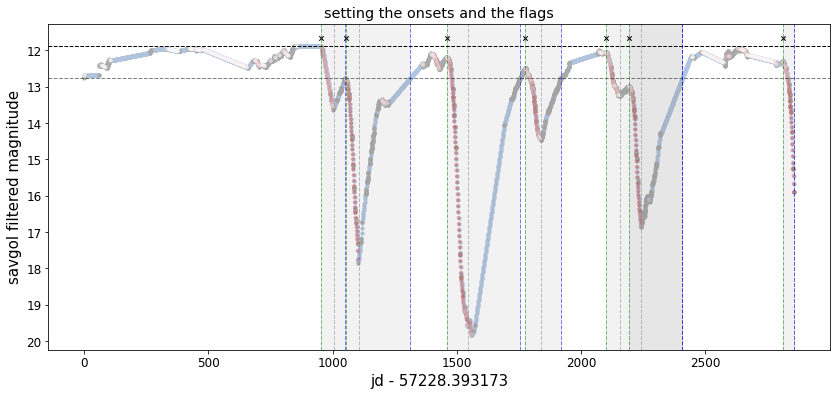

[951.6318200837148, 1052.6989219012282, 1459.969322294574, 1776.1792646147148, 2098.3931931814404, 2191.4549800035074, 2810.866227776188]
[ 955.238601 1051.128256 1461.057405 1776.084298 2098.235541 2193.122781
 2810.76663 ]
[ 955.238601 1051.128256 1461.057405 1776.084298 2098.235541 2193.122781
 2810.76663 ]


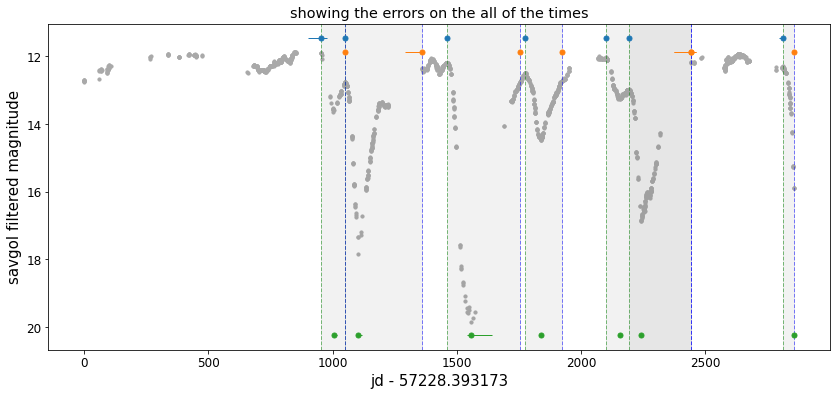

max light: 11.87
min decline depth: 0.9
length of light curve: 2856.896789000006
sampling percent of light curve: 14.25


onset_time  onset_err_l  onset_err_r  onset_flag      end_time  \
0  58183.631774    54.211052    22.983034         0.0  58279.521429   
1  58279.521429     3.001182     3.991214         0.0  58589.618851   
2  58689.450578     6.031089     2.976042         0.0  58983.565407   
3  59004.477471     0.978799     5.499919         0.0  59151.223909   
4  59326.628714     7.502410     2.481370         0.0  59670.615960   
5  59421.515954     3.090111     1.976011         0.0  59670.615960   
6  60039.159803    13.897673     2.627078         0.0  60085.289962   

   end_err_l  end_err_r  end_flag    depth_time  depth_err_l  depth_err_r  \
0   3.001182   3.991214       0.0  58233.573266     6.981450    12.984211   
1  70.206891   0.988982       0.0  58331.416165     7.975789    15.966360   
2   4.979925   1.995886       0.0  58787.283859    17.975076    81.159923   
3   5.971237   3.989817       0.0  59067.472874     8.021190     0.977386   
4  69.690188  21.001995       0.0  59385.514738     5.997366     4.002720   
5  69.690188  21.001995       0.0  59469.322207     9.440304     0.992477   
6   6.616886        NaN       1.0  60085.289962     6.616886          NaN   

   decline_depth  min_mag  sampling  
0          1.680   13.573     14.43  
1          5.085   17.843     14.79  
2          7.629   19.835     11.53  
3          1.911   14.446     32.65  
4          1.222   13.269     34.38  
5          3.876   16.863     16.80  
6          3.552   15.891     38.30

In [24]:
decline_detection(oband,use_iter_smooth=False,debug_mode=False)#,decline_min_depth=0.5)

In [ ]:
decline_detection(oband,use_iter_smooth=False,debug_mode=True)#,
#                  savefile='/Users/ccra8514/Desktop/ASAS-RCB-21')

In [645]:
# decline_detection(oband,use_iter_smooth=True,debug_mode=True)#,
# #                  savefile='/Users/ccra8514/Desktop/ASAS-RCB-21')

In [38]:
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_WISEJ194218.38-203247.5_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_AOHer_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-14_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-16_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-19_ATLAS.csv')
atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-11-07_ASAS-RCB-21_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-11-07_ASAS-RCB-7_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-11-07_EROS2-CG-RCB-10_ATLAS.csv')
atlas

mjd       m      dm      ujy   dujy  f  err  reduced_chi  \
0     57222.362628  24.171  42.000      1.0   33.0  o    0         4.02   
1     57222.374182  20.467   1.219     24.0   29.0  o    0         3.15   
2     57222.374867  22.438   7.600      4.0   29.0  o    0         3.26   
3     57229.387086  19.275   0.627     71.0   44.0  o    0         1.48   
4     57229.407449  18.781   0.416    112.0   46.0  o    0         0.99   
...            ...     ...     ...      ...    ... ..  ...          ...   
2755  60243.026378  11.586   0.001  84228.0  109.0  o    0      4857.55   
2756  60243.035029  11.577   0.001  84973.0  112.0  o    0      3852.07   
2757  60248.023746  11.750   0.001  72435.0   97.0  o    0      1199.18   
2758  60248.038254  11.834   0.001  67037.0   96.0  o    0      1533.17   
2759  60248.041436  11.758   0.002  71942.0  108.0  o    0      1283.54   

             ra      dec        x         y   maj   min   phi  apfit  mag5sig  \
0     284.67416 -2.33648  1567.35   4725.95  3.78  3.41 -71.9 -0.514    19.08   
1     284.67416 -2.33648  4921.35   8989.30  3.69  3.39 -73.0 -0.502    19.13   
2     284.67416 -2.33648  1571.27   4723.15  3.77  3.40 -66.9 -0.508    19.09   
3     284.67416 -2.33648  8899.09   5307.24  3.64  3.19  86.4 -0.480    18.79   
4     284.67416 -2.33648  7444.06   6764.66  3.59  3.18  88.9 -0.496    18.77   
...         ...      ...      ...       ...   ...   ...   ...    ...      ...   
2755  284.67416 -2.33648  5504.94   9900.47  2.56  1.96 -65.6 -0.484    18.37   
2756  284.67416 -2.33648  5480.81  10018.91  2.52  1.98 -63.8 -0.494    18.34   
2757  284.67416 -2.33648  1235.95   5203.10  2.44  2.09  71.9 -0.415    18.77   
2758  284.67416 -2.33648  1253.57   5247.06  2.43  2.22  81.8 -0.409    18.64   
2759  284.67416 -2.33648  1192.49   5169.65  2.41  2.11  71.4 -0.417    18.52   

        sky             obs  
0     20.68  02a57222o0093o  
1     20.83  02a57222o0110o  
2     20.68  02a57222o0111o  
3     20.11  02a57229o0203o  
4     20.11  02a57229o0228o  
...     ...             ...  
2755  19.04  04a60243o0089o  
2756  19.01  04a60243o0108o  
2757  20.14  04a60248o0071o  
2758  20.08  04a60248o0102o  
2759  19.88  04a60248o0109o  

[2760 rows x 19 columns]

In [39]:
oband = atlas[atlas['f']=='o']
oband = oband.sort_values(by=['mjd'],axis=0,ascending=True,ignore_index=True)
oband = oband.drop_duplicates(subset=['mjd'],ignore_index=True) 
oband

mjd       m      dm      ujy   dujy  f  err  reduced_chi  \
0     57222.362628  24.171  42.000      1.0   33.0  o    0         4.02   
1     57222.374182  20.467   1.219     24.0   29.0  o    0         3.15   
2     57222.374867  22.438   7.600      4.0   29.0  o    0         3.26   
3     57229.387086  19.275   0.627     71.0   44.0  o    0         1.48   
4     57229.407449  18.781   0.416    112.0   46.0  o    0         0.99   
...            ...     ...     ...      ...    ... ..  ...          ...   
2119  60243.026378  11.586   0.001  84228.0  109.0  o    0      4857.55   
2120  60243.035029  11.577   0.001  84973.0  112.0  o    0      3852.07   
2121  60248.023746  11.750   0.001  72435.0   97.0  o    0      1199.18   
2122  60248.038254  11.834   0.001  67037.0   96.0  o    0      1533.17   
2123  60248.041436  11.758   0.002  71942.0  108.0  o    0      1283.54   

             ra      dec        x         y   maj   min   phi  apfit  mag5sig  \
0     284.67416 -2.33648  1567.35   4725.95  3.78  3.41 -71.9 -0.514    19.08   
1     284.67416 -2.33648  4921.35   8989.30  3.69  3.39 -73.0 -0.502    19.13   
2     284.67416 -2.33648  1571.27   4723.15  3.77  3.40 -66.9 -0.508    19.09   
3     284.67416 -2.33648  8899.09   5307.24  3.64  3.19  86.4 -0.480    18.79   
4     284.67416 -2.33648  7444.06   6764.66  3.59  3.18  88.9 -0.496    18.77   
...         ...      ...      ...       ...   ...   ...   ...    ...      ...   
2119  284.67416 -2.33648  5504.94   9900.47  2.56  1.96 -65.6 -0.484    18.37   
2120  284.67416 -2.33648  5480.81  10018.91  2.52  1.98 -63.8 -0.494    18.34   
2121  284.67416 -2.33648  1235.95   5203.10  2.44  2.09  71.9 -0.415    18.77   
2122  284.67416 -2.33648  1253.57   5247.06  2.43  2.22  81.8 -0.409    18.64   
2123  284.67416 -2.33648  1192.49   5169.65  2.41  2.11  71.4 -0.417    18.52   

        sky             obs  
0     20.68  02a57222o0093o  
1     20.83  02a57222o0110o  
2     20.68  02a57222o0111o  
3     20.11  02a57229o0203o  
4     20.11  02a57229o0228o  
...     ...             ...  
2119  19.04  04a60243o0089o  
2120  19.01  04a60243o0108o  
2121  20.14  04a60248o0071o  
2122  20.08  04a60248o0102o  
2123  19.88  04a60248o0109o  

[2124 rows x 19 columns]

In [40]:
# plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd']-oband['mjd'][0],oband['ujy'],s=10)#/(80000),s=10)
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('o-band flux (ujy)')
# # plt.ylim(-100,1000)
# # plt.ylim(0.6,1.2)
# # plt.xlim(1000,2000)
# plt.show()

In [41]:
# plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10)#/(80000),s=10)
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('o-band mag')
# # plt.ylim(top=1.2)
# # plt.ylim(0.6,1.2)
# # plt.xlim(1000,2000)
# plt.show()

In [42]:
oband.rename(columns={'mjd': 'jd', 'm': 'mag'},inplace=True)

filtered first data point, resetting mjd_scale


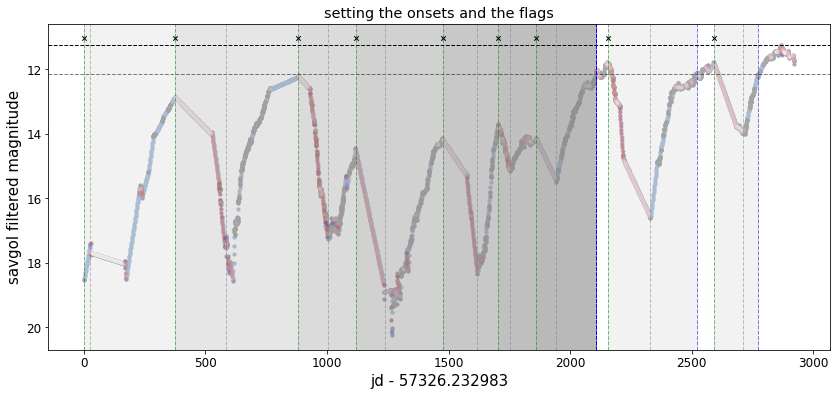

[0.0, 375.23224995719147, 882.5462518993144, 1117.691795205821, 1475.9135164982865, 1705.055343805478, 1861.1519597876697, 2157.3352824205463, 2592.604692370888]
[   0.        374.007458  882.351338 1116.013918 1474.017729 1704.171991
 1857.977526 2160.016528 2589.978132]
[   0.        374.007458  882.351338 1116.013918 1474.017729 1704.171991
 1857.977526 2160.016528 2589.978132]


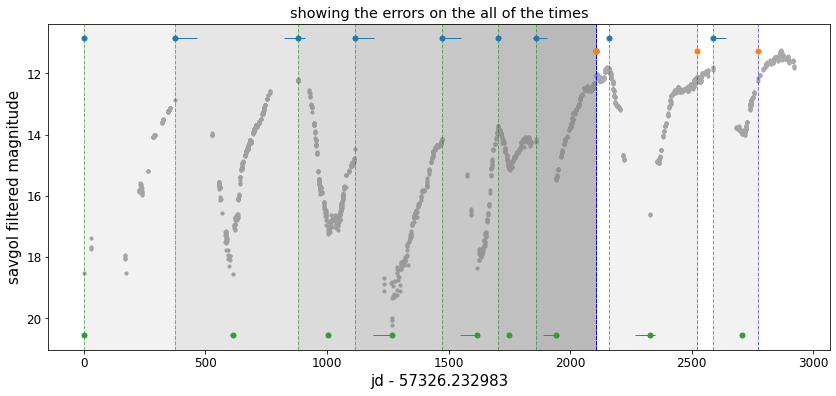

max light: 11.249
min decline depth: 0.9
length of light curve: 2921.808452999998
sampling percent of light curve: 17.25


onset_time  onset_err_l  onset_err_r  onset_flag      end_time  \
0  57326.232983          NaN   113.117581         1.0  59434.375326   
1  57700.240441    12.002388    91.183912         0.0  59434.375326   
2  58208.584321    58.193955    26.020659         0.0  59434.375326   
3  58442.246901     5.003276    77.181873         0.0  59434.375326   
4  58800.250712     2.988621    75.167559         0.0  59434.375326   
5  59030.404974     3.013247     4.026456         0.0  59434.375326   
6  59184.210509    11.991136    46.218519         0.0  59434.375326   
7  59486.249511     4.450205     2.994073         0.0  59848.255714   
8  59916.211115    12.986279    52.216903         0.0  60097.973194   

   end_err_l  end_err_r  end_flag    depth_time  depth_err_l  depth_err_r  \
0   6.433179   4.013496       0.0  57326.232983          NaN   113.117581   
1   6.433179   4.013496       0.0  57939.476016    11.450421     3.997945   
2   6.433179   4.013496       0.0  58328.425789     5.967639     4.006017   
3   6.433179   4.013496       0.0  58591.594514    77.683555    10.482102   
4   6.433179   4.013496       0.0  58944.570763    72.170036     6.016758   
5   6.433179   4.013496       0.0  59076.385876     3.477726     3.976809   
6   6.433179   4.013496       0.0  59268.663178    52.219621     9.975134   
7   2.604333   2.252526       0.0  59656.613201    63.196673    16.980319   
8  11.310128  14.090002       0.0  60034.367269     2.868835     1.999482   

   decline_depth  min_mag  sampling  
0       6.384297   18.541      6.13  
1       5.696000   18.563     14.73  
2       5.033000   17.263     23.83  
3       5.773000   20.232     17.27  
4       4.176000   18.347     12.99  
5       1.400000   15.109     30.52  
6       1.355000   15.483     19.05  
7       4.765000   16.613     19.01  
8       2.173000   13.954     16.39

In [43]:
decline_detection(oband,use_iter_smooth=False,debug_mode=False)#,decline_min_depth=0.5,
#                  savefile='/Users/courtneycrawford/Desktop/ASAS-RCB-16')#'/Users/ccra8514/Desktop/WISEJ194'

# Benchmarking with a Mira variable

In [162]:
# mira = pd.read_csv('/Users/ccra8514/Desktop/query_1699926198.65723l/I/OGLE-BLG-LPV-060312.dat',
#                    names=['jd','mag','magerr'],sep='\s+')
mira = pd.read_csv('/Users/ccra8514/Desktop/query_1699926198.65723l/I/OGLE-BLG-LPV-096697.dat',
                   names=['jd','mag','magerr'],sep='\s+')
mira

jd     mag  magerr
0     5260.85336  13.466   0.005
1     5260.90029  13.474   0.005
2     5261.79151  13.496   0.005
3     5262.82995  13.540   0.005
4     5264.81438  13.611   0.005
...          ...     ...     ...
8364  8784.51026  16.144   0.008
8365  8784.52408  16.117   0.008
8366  8785.50189  16.094   0.010
8367  8786.50070  16.099   0.010
8368  8787.50719  16.127   0.008

[8369 rows x 3 columns]

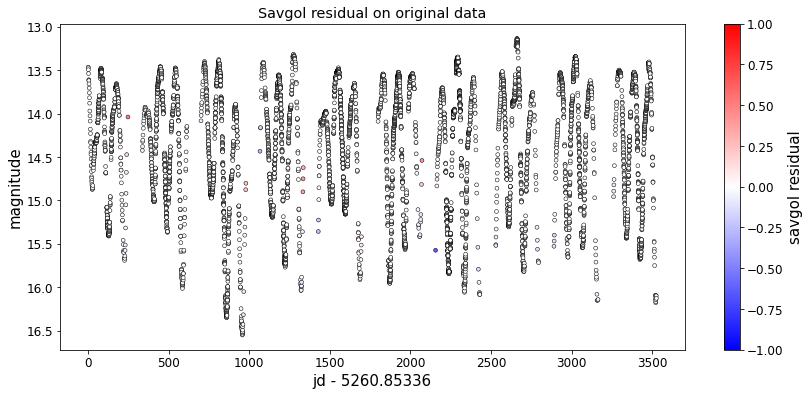

Std dev: 0.017033585893987957
95 percentile: 0.01251805090053466
99 percentile: 0.02108642621443443


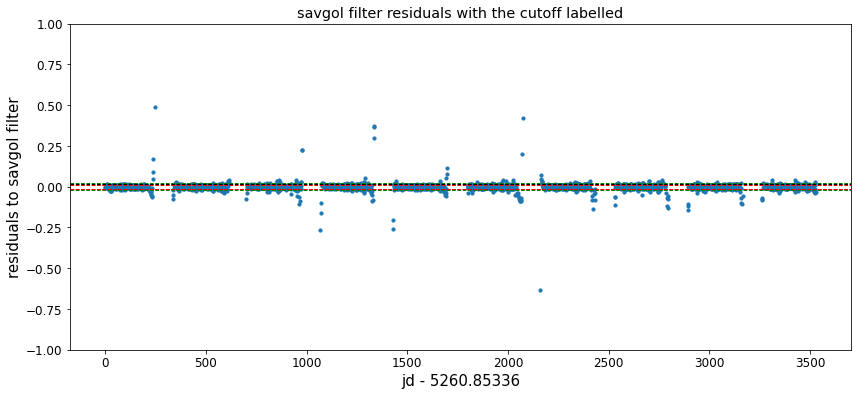

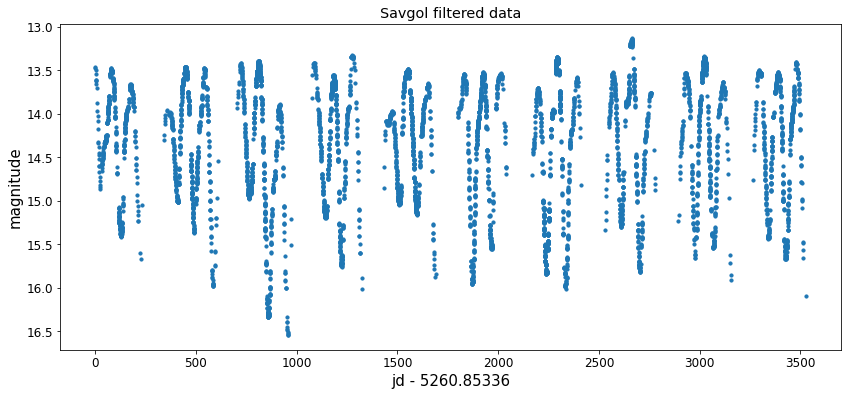

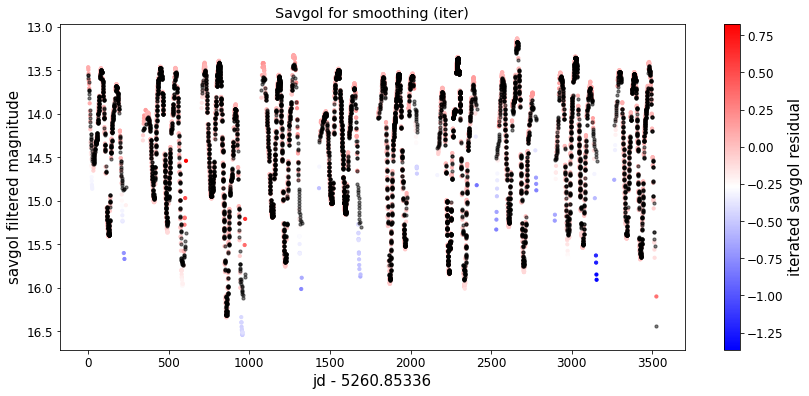

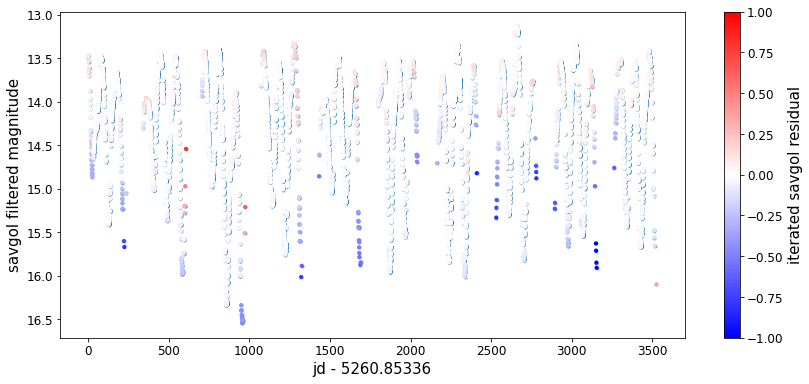

data resolution: 0.4684000717417298


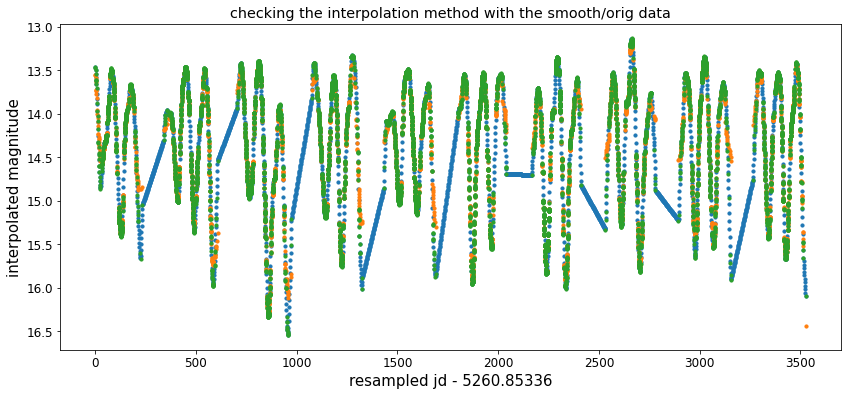

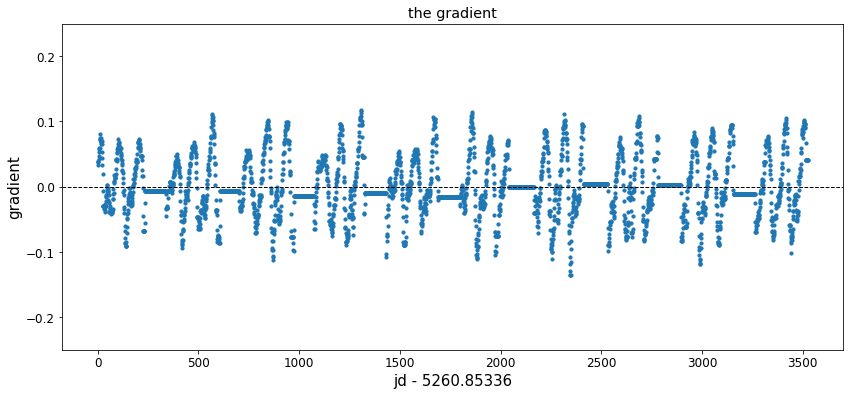

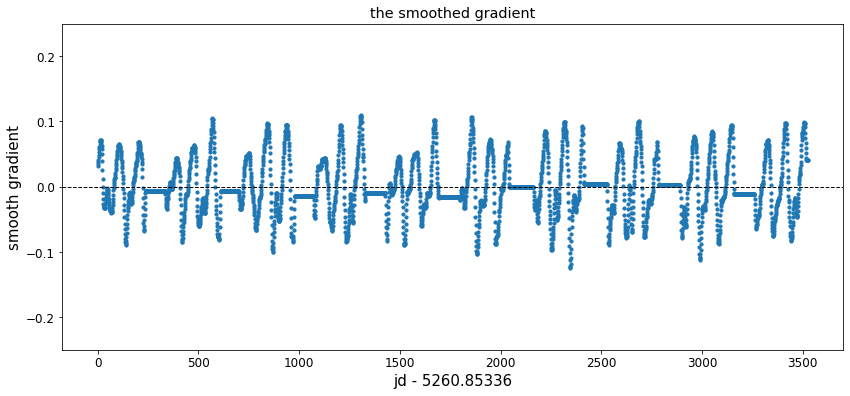

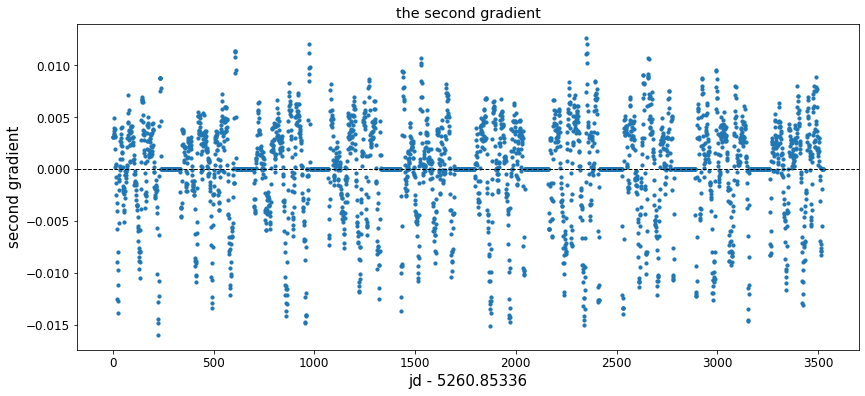

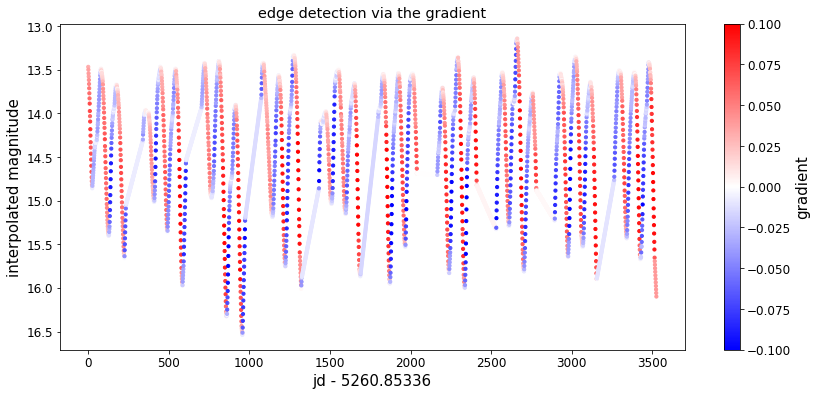

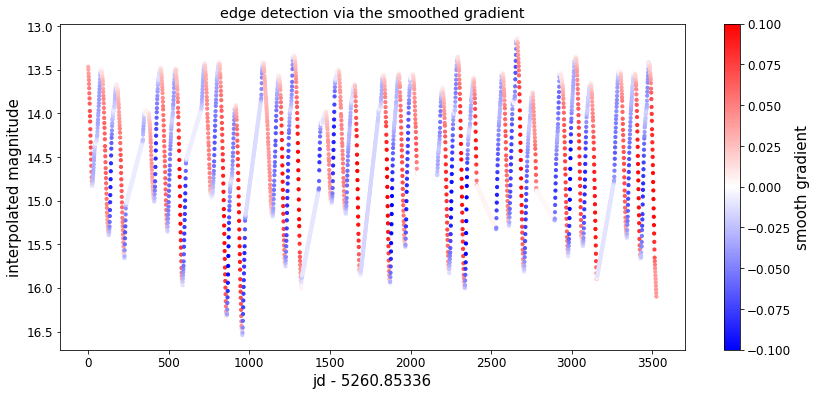

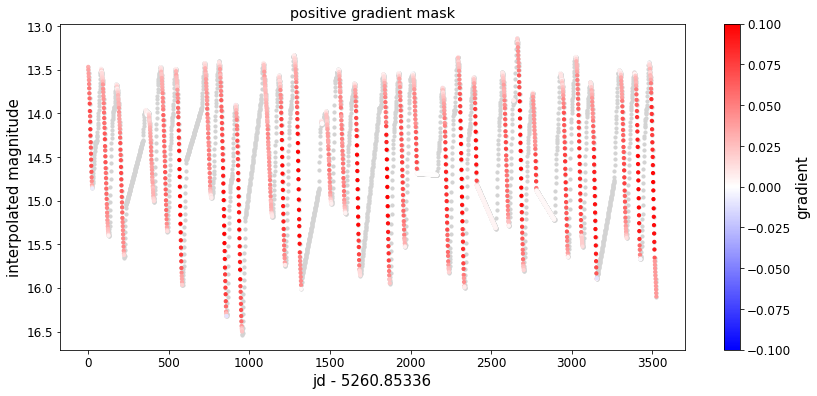

actually detecting the declines
0
13.466
1.3634537284837354
80
13.487228451198456
1.9144315119594921
175
13.672980048732878
1.9686425254107522
372
13.988448841238224
1.0246916878856354
449
13.469908083469925
1.8920570137137975
542
13.48937169922625
2.4814630829244884
722
13.42307613910083
1.5473560186351065
812
13.411787799635938
2.8917688672364363
914
13.90182185836035
2.6268614809697866
1086
13.422007090588275
1.7668860586878754
1183
13.565961041982076
2.187674316230895
1275
13.333814135920026
2.6381442732095
1474
13.975437821311889
1.0596930017306665
1551
13.507233088551931
1.6463759227014751
1652
13.658527839438221
2.208733264250535
1830
13.549340435686265
2.4008031570423487
1925
13.536504393951839
1.9953057786048856
2012
13.539630173923427
1.1649629495427156
2197
13.703044506140525
2.118879820596785
2292
13.358619936436474
2.6448958000631055
2391
13.588072818614439
1.730061202411905
2569
13.532795174493364
1.7576383950818641
2660
13.14054514601439
2.6637962464995404
2756
13.763592

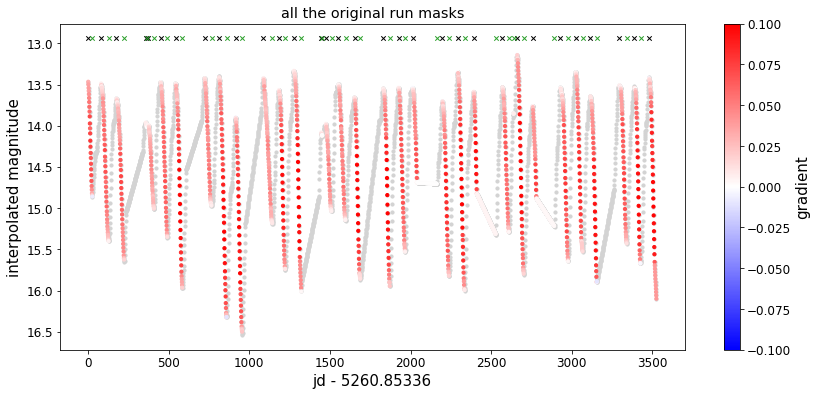

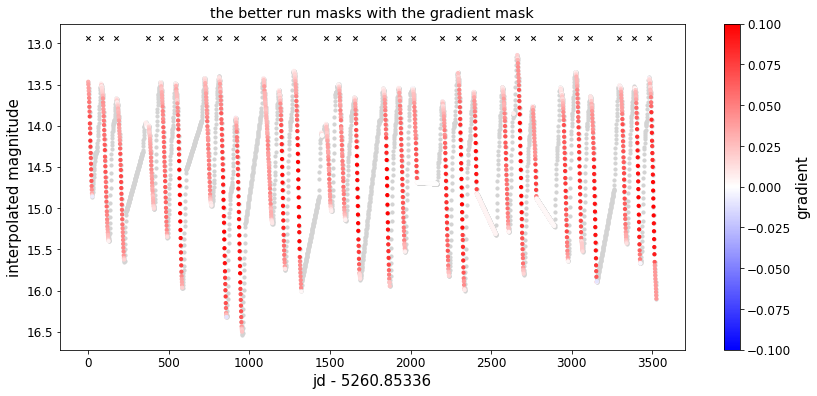

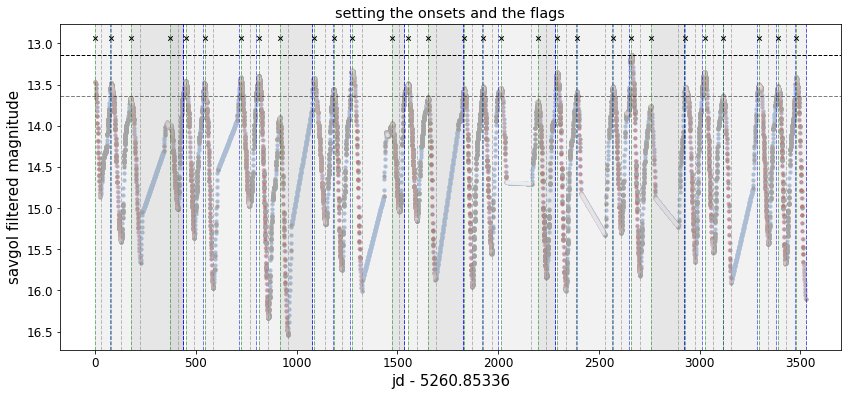

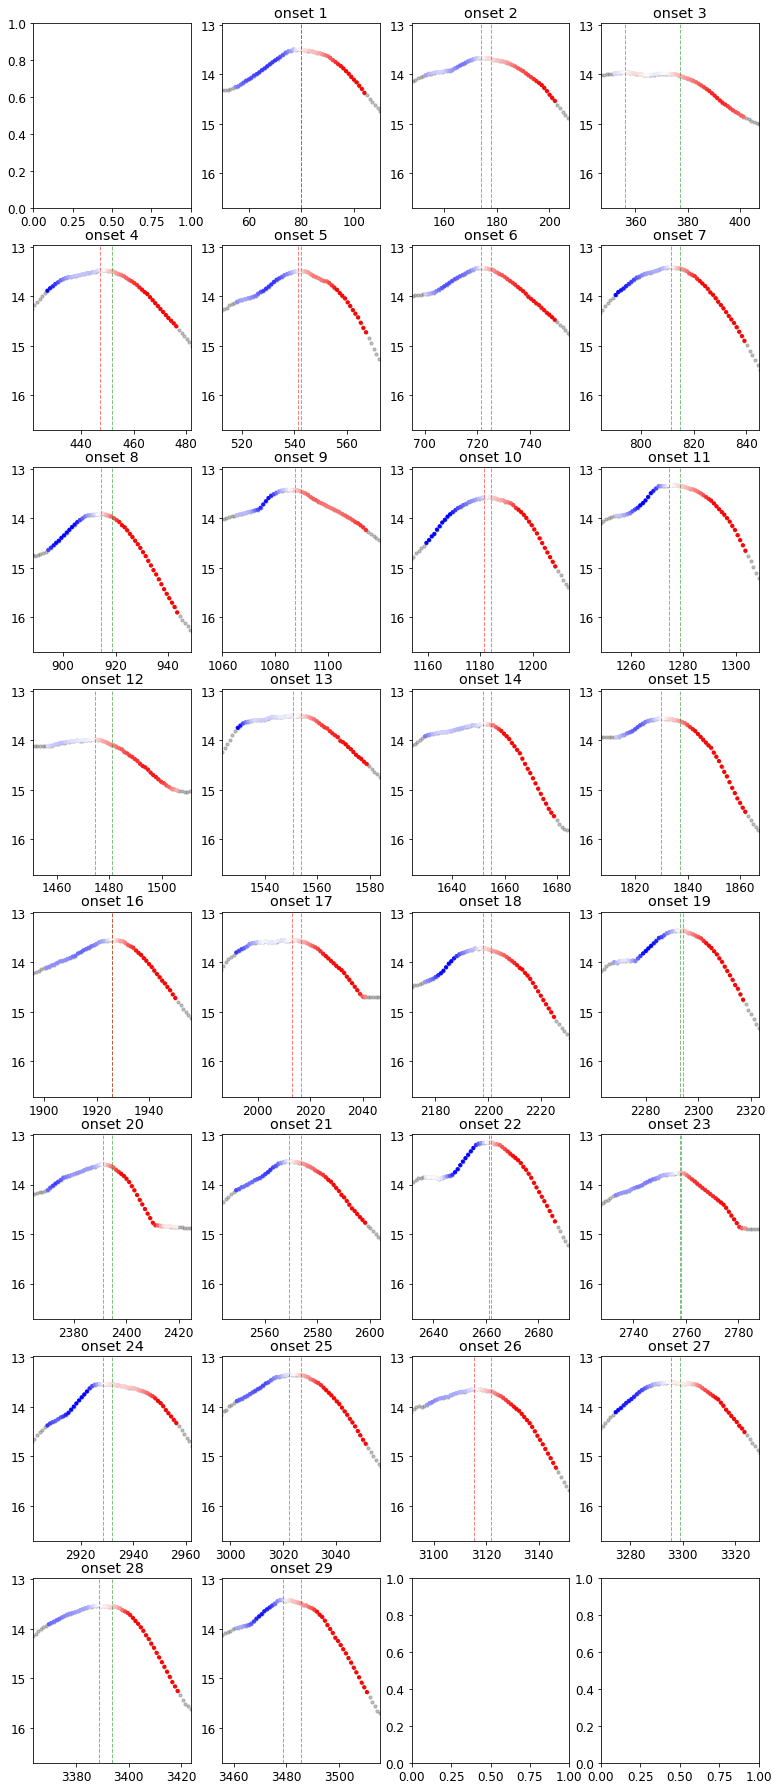

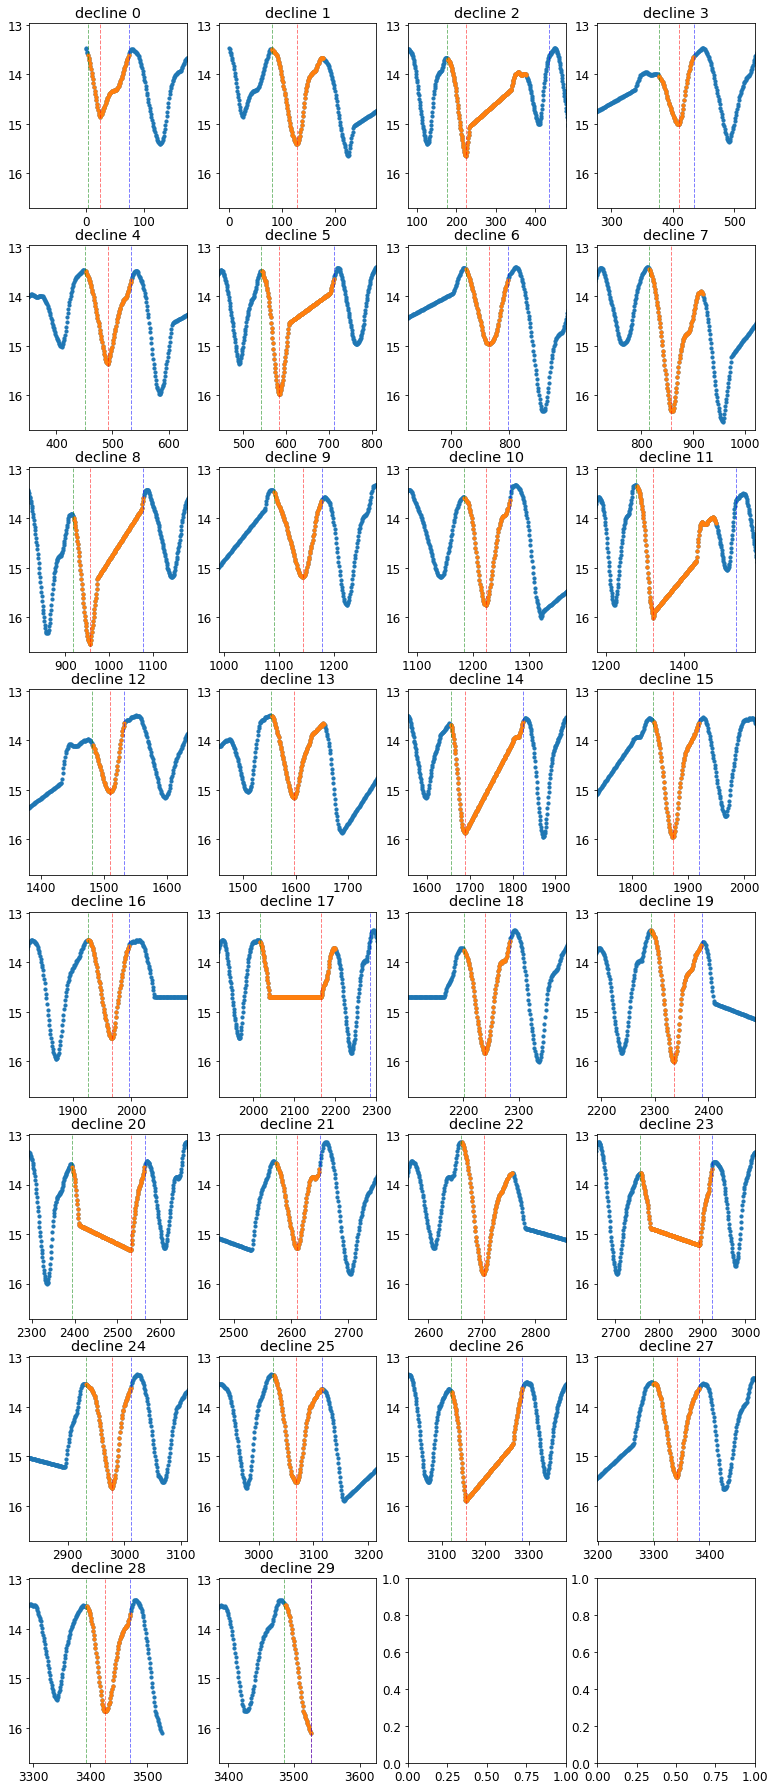

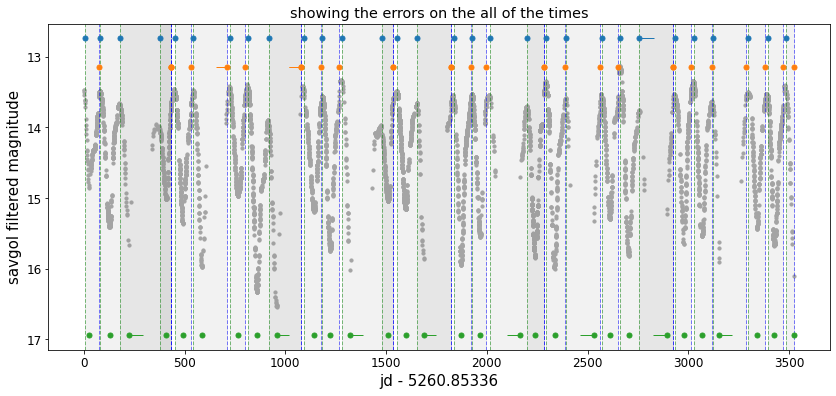

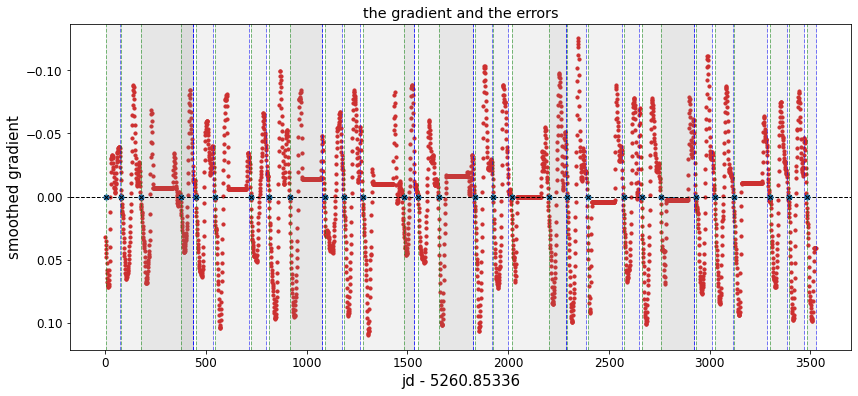

    onset_time  onset_err_l  onset_err_r  onset_flag    end_time  end_err_l  \
0   5264.81438          NaN     5.483810         1.0  5334.76488   3.450840   
1   5340.87518     1.019690     0.916920         0.0  5694.88860   0.590665   
2   5438.49893     1.916585     2.554500         0.0  5694.88860   0.590665   
3   5637.81281     9.961500     2.046440         0.0  5694.88860   0.590665   
4   5712.64641     1.958965     0.966675         0.0  5794.67664   0.600295   
5   5803.50972     3.449430     1.066235         0.0  5972.87575  56.691110   
6   5985.81385     3.974670     1.545900         0.0  6058.90187   0.546620   
7   6075.62076     2.408630     0.607330         0.0  6338.84197  62.166225   
8   6179.52504     3.483610     1.520640         0.0  6338.84197  62.166225   
9   6350.84491     7.986425     4.986290         0.0  6437.91925   0.569345   
10  6444.77593     1.031725     0.552185         0.0  6526.63343   1.520805   
11  6539.48018     3.472525     6.003000         0.0

onset_time  onset_err_l  onset_err_r  onset_flag    end_time  end_err_l  \
0   5264.81438          NaN     5.483810         1.0  5334.76488   3.450840   
1   5340.87518     1.019690     0.916920         0.0  5694.88860   0.590665   
2   5438.49893     1.916585     2.554500         0.0  5694.88860   0.590665   
3   5637.81281     9.961500     2.046440         0.0  5694.88860   0.590665   
4   5712.64641     1.958965     0.966675         0.0  5794.67664   0.600295   
5   5803.50972     3.449430     1.066235         0.0  5972.87575  56.691110   
6   5985.81385     3.974670     1.545900         0.0  6058.90187   0.546620   
7   6075.62076     2.408630     0.607330         0.0  6338.84197  62.166225   
8   6179.52504     3.483610     1.520640         0.0  6338.84197  62.166225   
9   6350.84491     7.986425     4.986290         0.0  6437.91925   0.569345   
10  6444.77593     1.031725     0.552185         0.0  6526.63343   1.520805   
11  6539.48018     3.472525     6.003000         0.0  6792.91837   0.544090   
12  6741.91535     3.059695     1.977735         0.0  6792.91837   0.544090   
13  6814.75243     1.431895     0.561140         0.0  7084.81902   3.476380   
14  6915.51998     2.996770     3.516870         0.0  7084.81902   3.476380   
15  7097.79549     3.490745     1.032680         0.0  7180.75032   0.528695   
16  7186.69890     0.948635     0.607205         0.0  7257.69709   1.102780   
17  7277.49883     2.961160     7.538410         0.0  7545.58854   4.405130   
18  7461.79519     2.501785     2.049740         0.0  7545.58854   4.405130   
19  7553.85406     1.508260     0.478515         0.0  7648.58717   5.025750   
20  7655.48129     2.949110     5.002420         0.0  7824.87871   2.496960   
21  7834.78845     4.002180     2.006055         0.0  7910.92758   0.539755   
22  7922.61741     2.883775     0.636305         0.0  8183.88494   4.032060   
23  8018.50224     2.488425    71.673315         0.0  8183.88494   4.032060   
24  8192.78559     3.953290     1.552255         0.0  8272.64530   3.416180   
25  8287.81438     1.454580     0.868295         0.0  8376.51386   2.955245   
26  8382.48308     5.492830     1.518260         0.0  8546.84753   6.492465   
27  8559.77378     1.940625     1.543165         0.0  8642.56196   1.000305   
28  8654.52240     3.326985     1.508530         0.0  8731.62230   1.007540   
29  8746.53486     3.027995     0.979885         0.0  8786.50070   9.983725   

    end_err_r  end_flag  depth_time  depth_err_l  depth_err_r  decline_depth  \
0    0.588190       0.0  5285.76013     3.988530     5.045375       1.221455   
1    0.976100       0.0  5387.80776     0.581900     0.957995       1.918000   
2    0.976100       0.0  5485.49798    10.006935    69.669855       1.992000   
3    0.976100       0.0  5669.91810     1.046790     2.975865       0.994000   
4    3.454175       0.0  5752.54609     1.969885     4.056960       1.873000   
5    5.012125       0.0  5845.57865     2.992585     6.976150       2.479000   
6    1.410720       0.0  6025.88224     0.991155     3.516700       1.527000   
7    6.025870       0.0  6118.50595     0.895790     0.616445       2.899000   
8    6.025870       0.0  6217.54594     6.029305    63.647935       2.574000   
9    2.396615       0.0  6403.68468     0.964080     0.592950       1.730000   
10   3.457940       0.0  6483.58443     1.484260     1.471230       2.188000   
11   2.399905       0.0  6582.49944     6.496090    61.680710       2.662000   
12   2.399905       0.0  6769.70142     1.965660     0.593410       0.944000   
13   2.009945       0.0  6857.57209     0.896380     0.577740       1.647000   
14   2.009945       0.0  6949.52687     6.012505    60.158010       2.195000   
15   0.540675       0.0  7132.72591     1.397870     1.077330       2.340000   
16   2.967930       0.0  7227.78390     0.612405     0.990480       1.986000   
17   0.085145       0.0  7426.88843    66.700955     5.976395       1.137000   
18   0.085145       0.0  7500.9074

In [180]:
decline_detection(mira,use_iter_smooth=False,debug_mode=True,decline_min_depth=0.5)#,
#                  savefile='/Users/ccra8514/Desktop/mira1')

# Benchmarking with a DY Per from OGLE

In [11]:
# dyper = pd.read_csv('/Users/ccra8514/Desktop/LMC-DYPer-3.txt',
#                    names=['jd','mag','magerr','seeing','skyerr'],sep='\s+')
# dyper = pd.read_csv('/Users/ccra8514/Desktop/LMC-DYPer-9.txt',
#                    names=['jd','mag','magerr','seeing','skyerr'],sep='\s+')
dyper = pd.read_csv('/Users/ccra8514/Desktop/Wmen.txt',
                   names=['jd','mag','magerr','seeing','skyerr'],sep='\s+')
dyper

jd     mag  magerr  seeing  skyerr
0    2.455261e+06  13.442   0.003    5.28   480.0
1    2.455262e+06  13.446   0.003    6.12   458.0
2    2.455262e+06  13.443   0.003    5.12   443.0
3    2.455263e+06  13.438   0.003    5.26   381.0
4    2.455265e+06  13.444   0.003    5.15   419.0
..            ...     ...     ...     ...     ...
834  2.459950e+06  13.424   0.003    5.40   615.0
835  2.459955e+06  13.428   0.003    5.98   553.0
836  2.459958e+06  13.443   0.003    3.92   367.0
837  2.459962e+06  13.451   0.003    5.35   305.0
838  2.459965e+06  13.457   0.003    5.19   457.0

[839 rows x 5 columns]

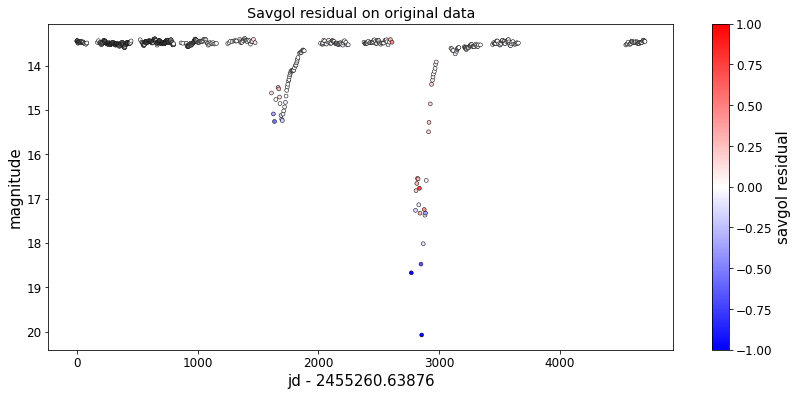

Std dev: 0.11765303055529601
95 percentile: 0.03949463435943574
99 percentile: 0.2655195949955831


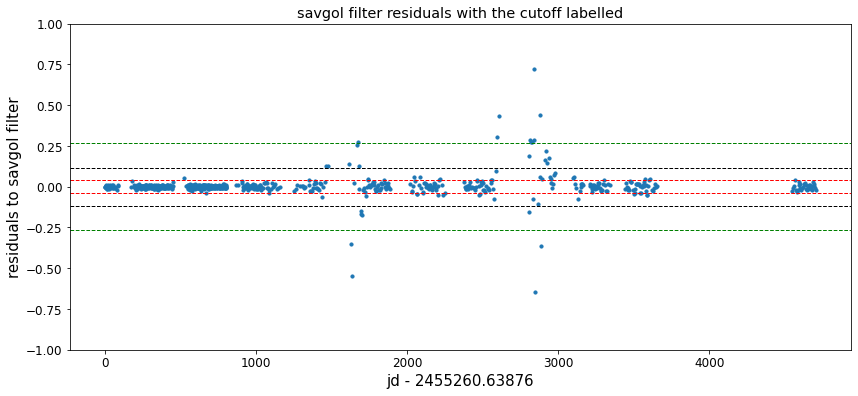

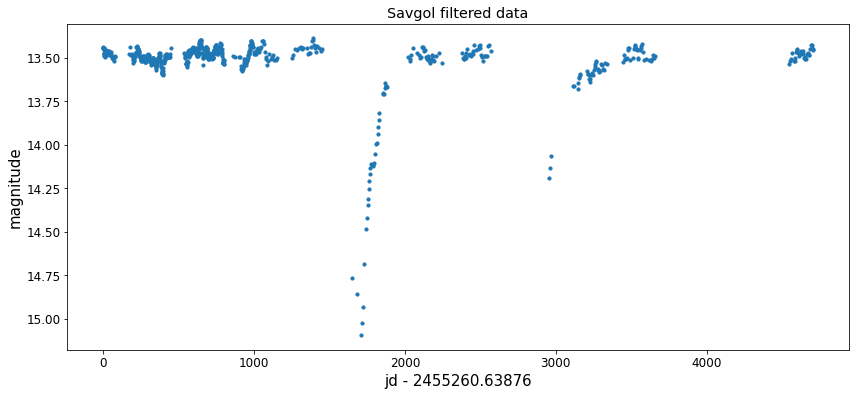

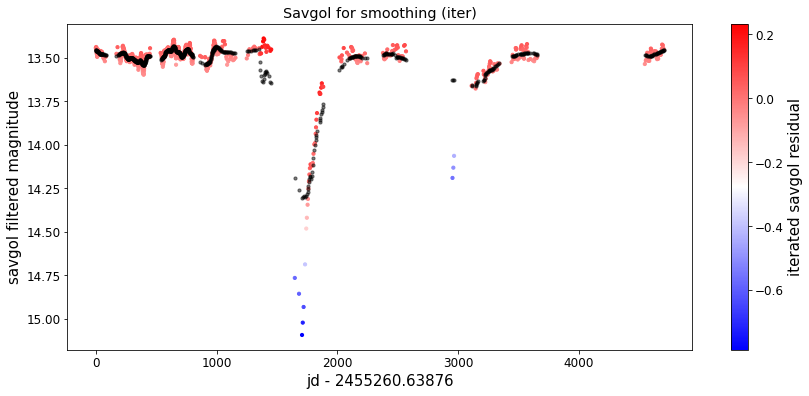

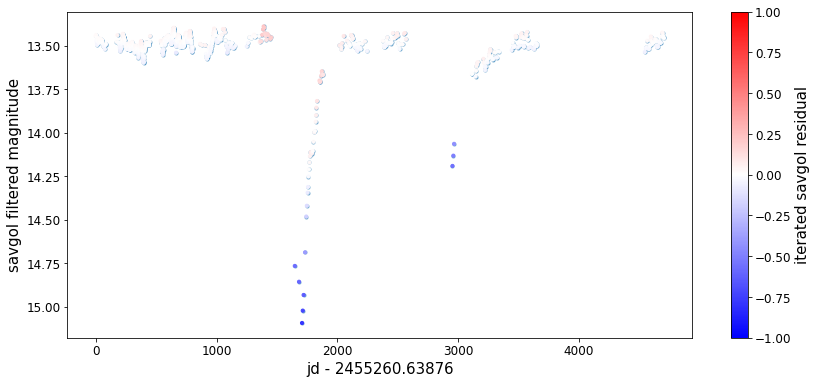

data resolution: 6.109314181818324


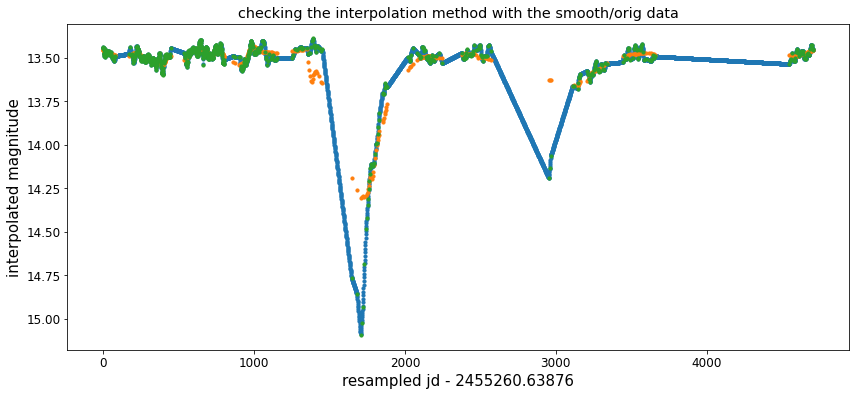

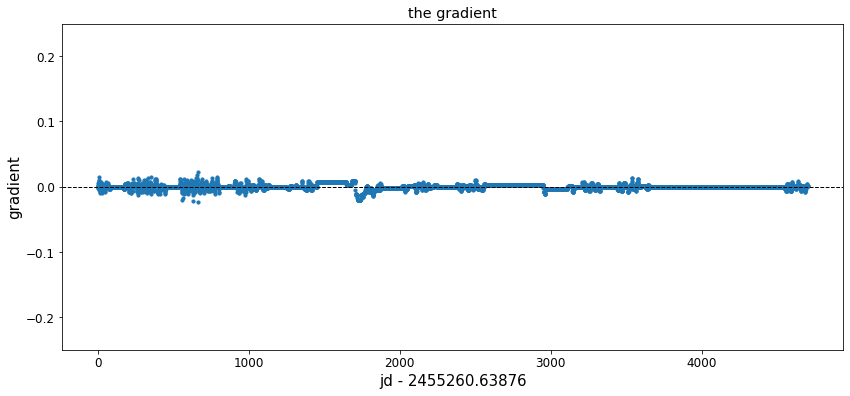

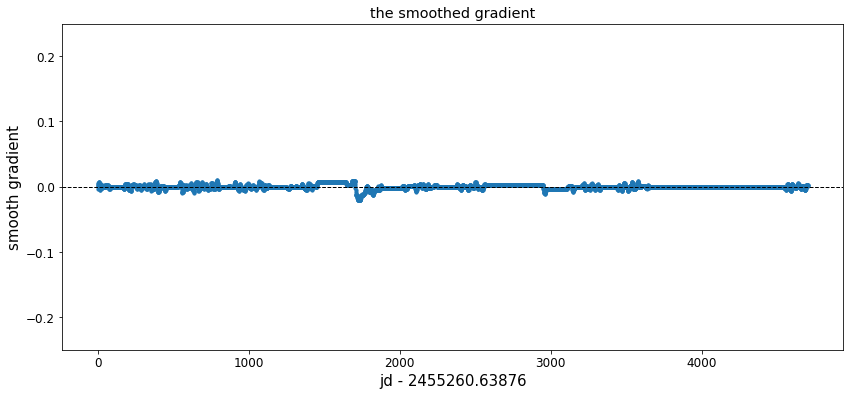

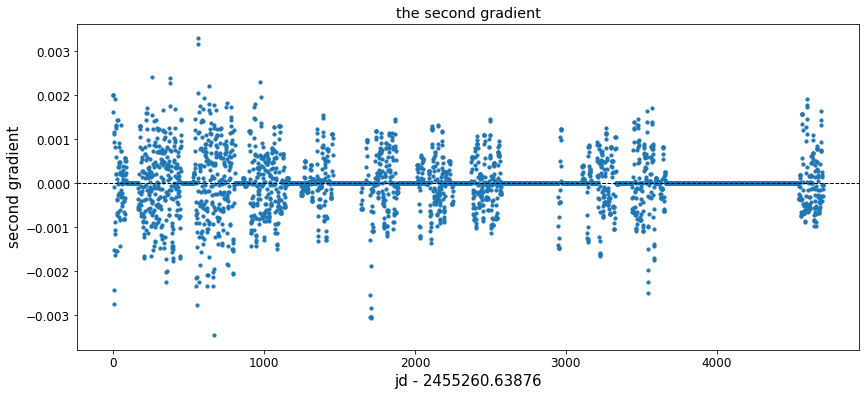

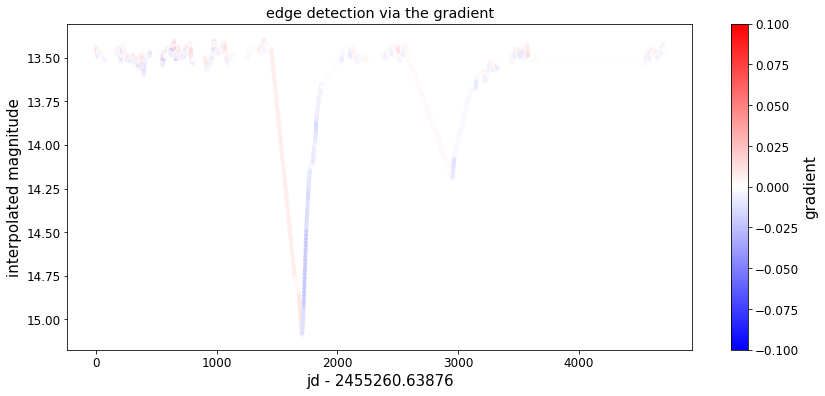

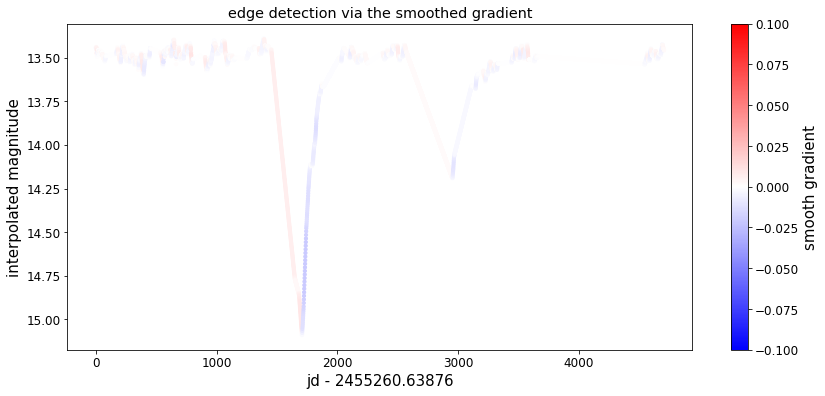

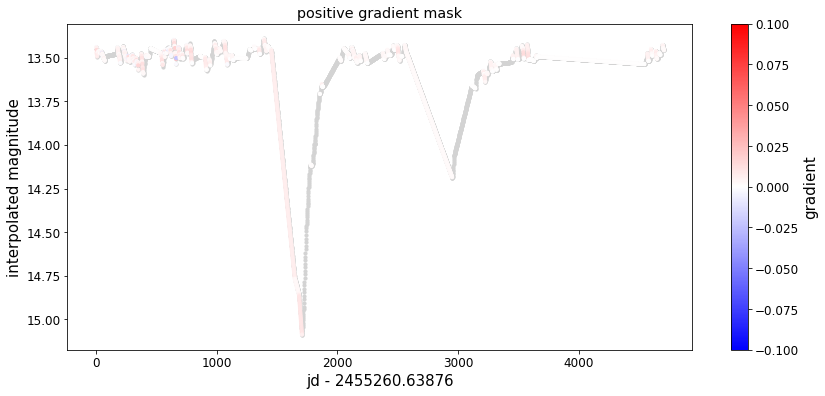

actually detecting the declines
1450
13.45389217456031
1.6360496302955756
2556
13.427848955702636
0.7590698068246926
[15.0899418  14.18691876]
[1.6360496302955756, 0.7590698068246926]


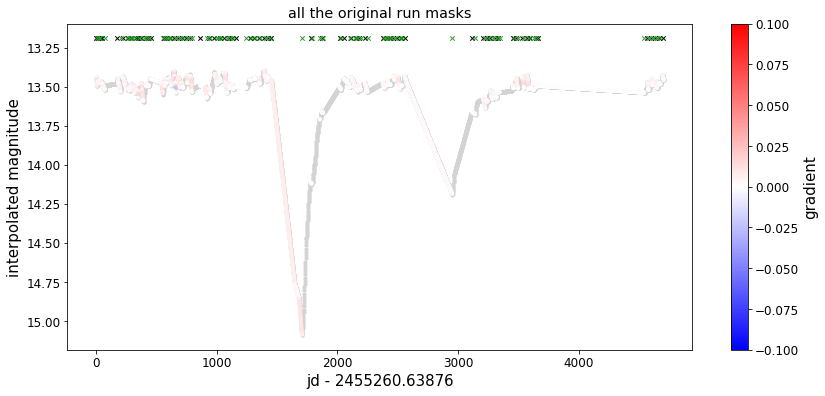

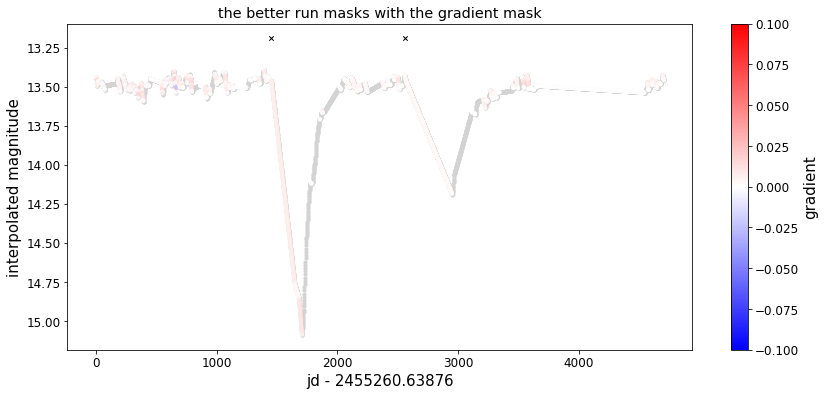

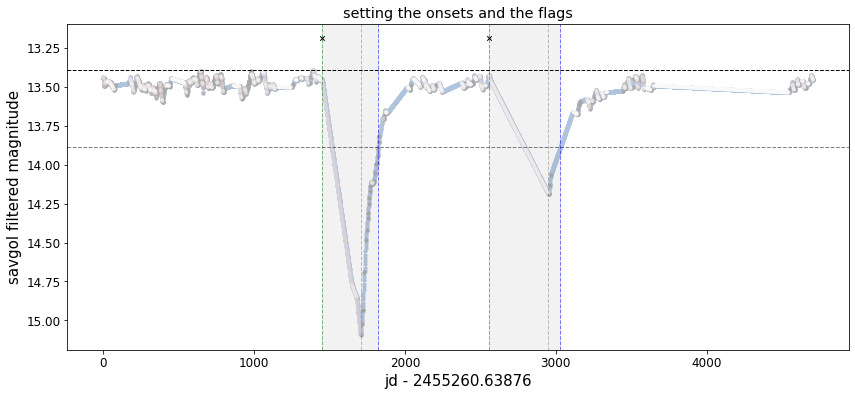

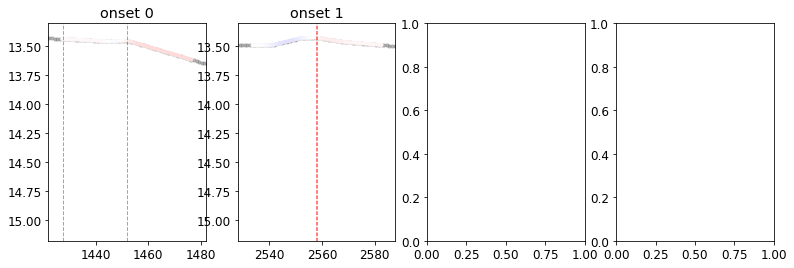

[1450.3613191580182, 2556.636918460617]
[1452.00924 2557.90071]
[1452.00924 2557.90071]


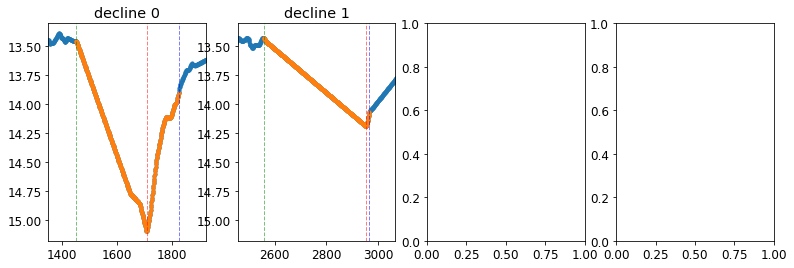

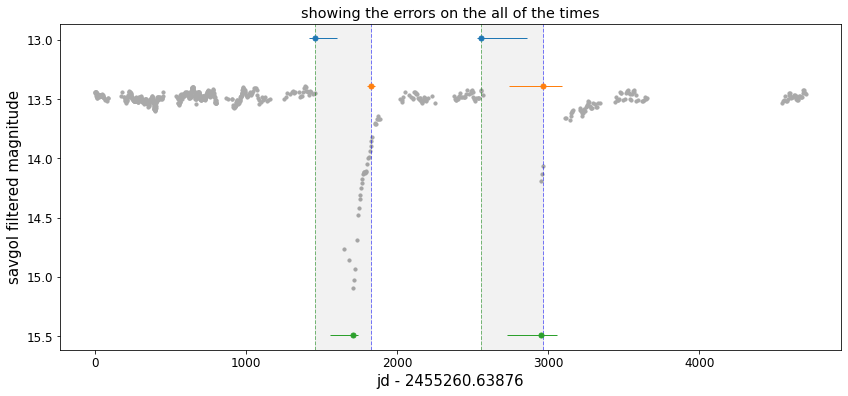

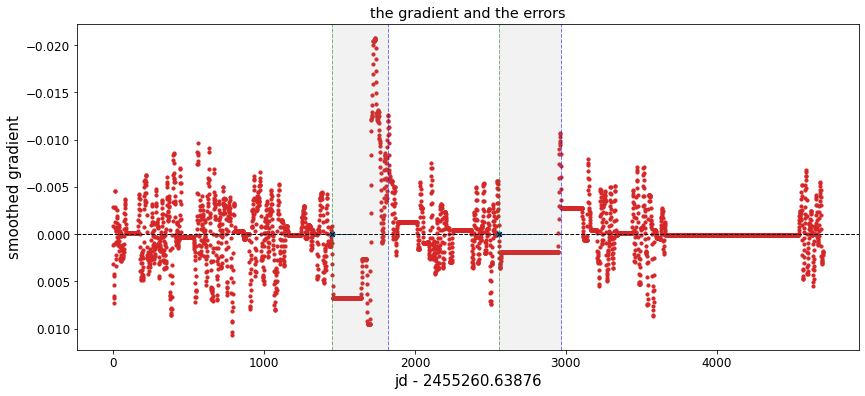

     onset_time  onset_err_l  onset_err_r  onset_flag      end_time  \
0  2.456713e+06    33.454390   152.069235         0.0  2.457084e+06   
1  2.457819e+06    31.411855   298.603940         0.0  2.458227e+06   

    end_err_l  end_err_r  end_flag    depth_time  depth_err_l  depth_err_r  \
0   25.423705   29.94122       0.0  2.456968e+06   154.471025    30.498315   
1  225.396210  123.13169       0.0  2.458214e+06   224.380155   105.111225   

   decline_depth  min_mag  sampling  
0          1.642   15.094      6.74  
1          0.764   14.191      1.22  
max light: 13.389
min decline depth: 0.5
length of light curve: 4704.17192000011
sampling percent of light curve: 16.0


onset_time  onset_err_l  onset_err_r  onset_flag      end_time  \
0  2.456713e+06    33.454390   152.069235         0.0  2.457084e+06   
1  2.457819e+06    31.411855   298.603940         0.0  2.458227e+06   

    end_err_l  end_err_r  end_flag    depth_time  depth_err_l  depth_err_r  \
0   25.423705   29.94122       0.0  2.456968e+06   154.471025    30.498315   
1  225.396210  123.13169       0.0  2.458214e+06   224.380155   105.111225   

   decline_depth  min_mag  sampling  
0          1.642   15.094      6.74  
1          0.764   14.191      1.22

In [12]:
decline_detection(dyper,use_iter_smooth=False,debug_mode=True,decline_min_depth=0.5)

In [265]:
# from astropy.timeseries import LombScargle
# def calc_lomb_scargle(t,y):
#    oversample = 1
#    tmax = t.max()
#    tmin = t.min()
#    df = 1.0 / (tmax - tmin)
#    fmin = df
#    fmax = 1 # maximum frequency in cycles per day (c/d)
 
#    freq = np.arange(fmin, fmax, df / oversample)
#    model = LombScargle(t, y)
#    sc = model.power(freq, method="fast", normalization="psd")
 
#    fct = np.sqrt(4./len(t))
#    amp = np.sqrt(sc) * fct
#    return freq, amp*1E6 # return frequency in muHz and amplitude in ppm

In [264]:
# # freq, amp = calc_lomb_scargle(dyper['jd'][dyper['jd']-dyper['jd'][0]<1000],
# #                               dyper['mag'][dyper['jd']-dyper['jd'][0]<1000])
# freq, amp = calc_lomb_scargle(dyper['jd'],
#                               dyper['mag'])

In [263]:
# plt.figure(figsize=(14,5))
# plt.plot(freq,amp**2)
# plt.axvline(11.574/84,color='k',alpha=0.5)
# # plt.axvline(3.4e-2,color='k')
# plt.xlabel('freq [uHz]')
# plt.ylabel('power')
# plt.yscale('log')
# plt.xscale('log')
# plt.show()

In [261]:
# plt.figure(figsize=(14,5))
# plt.plot(freq,amp**2)
# plt.axvline(11.574/84.5,color='k',alpha=0.5)
# plt.axvline(11.574/80.2,color='k',alpha=0.5)
# plt.xlabel('freq [uHz]')
# plt.ylabel('power')
# plt.xlim(10**-1,2e-1)
# plt.ylim(-0.1e8,0.6e8)
# plt.show()

In [260]:
# peaks, prop = sp.signal.find_peaks(dyper['mag'],prominence=(0.05))

In [259]:
# np.diff((dyper['jd']-dyper['jd'][0])[peaks])

In [262]:
# plt.figure(figsize=(14,5))
# plt.scatter((dyper['jd']-dyper['jd'][0]),dyper['mag'])
# plt.scatter((dyper['jd']-dyper['jd'][0])[peaks],dyper['mag'][peaks],marker='x',color='k')
# # plt.xlim(0,1000)
# plt.show()

In [257]:
# plt.figure(figsize=(14,5))
# plt.scatter((dyper['jd']-dyper['jd'][0])%83,dyper['mag'])
# plt.show()

In [256]:
# from ipywidgets import interact, IntSlider, FloatSlider, fixed

In [255]:
# def phase_wrapper(time,flux,phase):
#     plt.figure(figsize=(14,5))
#     plt.scatter((time)%phase,flux)
# #     plt.show()

In [254]:
# interact(phase_wrapper,
#          time=fixed(dyper['jd']-dyper['jd'][0]),
#          flux=fixed(dyper['mag']),
#          phase=FloatSlider(min=20,max=60,step=0.5,value=40))

In [253]:
# 11.574/84.5